# Case Study - Clustering

-----------------------------------------
## Context
-----------------------------------------

Study of socio-economic factors is foundational to understanding and shaping the future of societies and hence of extreme interest to various government and non-government institutions. While GDP is one of the most popular measure used on popular vernacular, it is not the only measure of the growth and the state of an economy. This case study aims to deep dive into one such dataset that contains various socio-economic attributes for countries around the world.

-----------------------------------------
## Objective
-----------------------------------------

To identify if there exist various cluster of countries that are more similar to each other in terms of certain socio-economic factors

------------------------
## Data Dictionary
-------------------------
The data has the following attributes:
- country: Name of the country
- child_mort: Death of children under 5 years of age per 1000 live births
- exports - Exports in % age of the GDP per capita
- health - The total spend on health given as % of GDP
- imports - The value of imports given as % of GDP per capita
- income - The net income per person
- inflation - Inflation rate %
- life_expec - Average life expectancy in years
- total_fer - The fertility rate - Average children per woman in the country
- gdpp - GDP per capita

In the dataset, we will not do clustering on the gdp and would rather try to understand the variation of other factors with GDP across the groups that we formed.

## Importing libraries and overview of the dataset

In [1]:
# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Fit notebook cell width to window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [69]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

In [70]:
sns.set(font_scale=1.025, rc={'figure.figsize': (10, 6),
                              'axes.facecolor': '#f2f2f0',
                              'axes.edgecolor': '#f2f2f0',
                              'figure.facecolor': '#f2f2f0', 
                              'grid.color': '#c4c4c4', 
                              'grid.linewidth': 0.5,
                              'lines.linewidth': 1.5,
                              'text.color': '#000000',
                              'xtick.color': '#000000',
                              'ytick.color': '#000000'})

#### Utility Functions 

In [71]:
def triag_corr(df: pd.DataFrame, fig_xy: list = [13,10], cmap: str = 'rocket', annot: bool = True, annot_s: int = 8, 
               fmt: str = ".3%", abs_: bool = False, method: str = 'pearson') -> plt.figure:
    plt.figure(figsize=(fig_xy[0], fig_xy[1]))
    corr = df.corr(method=method).abs() if abs_ else df.corr(method=method)
    mask = np.tri(*corr.shape).T 
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=annot, annot_kws={"size":annot_s}, fmt=fmt)
    plt.show()
    
def get_redundant_pairs(df: pd.DataFrame) -> set:
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def mu_std_corr_matrix(corr: pd.DataFrame or np.array, rnd: int = 3):
    corr = corr.abs().copy()
    corr.values[np.tril_indices_from(corr)] = np.nan     
    return (round(corr.unstack().mean(),rnd), round(corr.unstack().std(),rnd))

def get_top_abs_correlations(df: pd.DataFrame, n: int = 5) -> pd.Series:
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)\
                     .to_frame().rename(columns={0:'Correlation'}).rename_axis(['X', 'y'])
    return au_corr[0:n]

#### Loading data

In [72]:
data = pd.read_csv("Country-data.csv")
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

#### Check the info of the data

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


**Observations:**
 
 - There are 167 observations and 10 columns in the data.
 - All columns have 167 non-null values i.e. there are no missing values.
 - All the columns except the country name are numerical.
 - Everything looks great, lets move ahead to check duplicates.

#### Check duplicate entries

In [75]:
data.country.nunique() #== len(data)

167

In [76]:
data[data.duplicated()]

Empty DataFrame
Columns: [country, child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp]
Index: []

- There are no duplicate rows in the data. That's good. 

## Exploratory Data Analysis

#### Summary Statistics

In [77]:
data.describe().T

count          mean           std       min       25%      50%  \
child_mort  167.0     38.270060     40.328931    2.6000     8.250    19.30   
exports     167.0     41.108976     27.412010    0.1090    23.800    35.00   
health      167.0      6.815689      2.746837    1.8100     4.920     6.32   
imports     167.0     46.890215     24.209589    0.0659    30.200    43.30   
income      167.0  17144.688623  19278.067698  609.0000  3355.000  9960.00   
inflation   167.0      7.781832     10.570704   -4.2100     1.810     5.39   
life_expec  167.0     70.555689      8.893172   32.1000    65.300    73.10   
total_fer   167.0      2.947964      1.513848    1.1500     1.795     2.41   
gdpp        167.0  12964.155689  18328.704809  231.0000  1330.000  4660.00   

                 75%        max  
child_mort     62.10     208.00  
exports        51.35     200.00  
health          8.60      17.90  
imports        58.75     174.00  
income      22800.00  125000.00  
inflation      10.75     104.00  
life_expec     76.80      82.80  
total_fer       3.88       7.49  
gdpp        14050.00  105000.00

**Observations:**

- The child mortality rate has a high range from 2.6 to 208 deaths per 1000 live births. The average child mortality rate is approx 38 deaths per 1000 live births.
- Similarly, the exports and imports have a high range of values. The maximum values for exports and imports is 200% and 174% of GDP respectively. This can happen if a country's  export or import industry exceeds their its domestic economy.
- The total spend on heath is very less as compared to exports and imports for majority of counties. The average spend on health is approx 6.8% of GDP.
- The average life expectancy is approx 70 years but the minimum value is just 32 years.
- Other variables like gdpp, inflation, and income also shows a high variability which can be expected as they can be very different for different countries.
- Overall, % expenditure on health, average life expectancy seem to have lesser standard deviation which reflects less variability across countries. All other variables seem to have very high spread across countries. These are the variables that might help us identify the clusters, if they exist. 

#### Let's check the distribution and outliers for each column in the data

            count      mean        std  min   25%   50%   75%    max      skew
child_mort  167.0  38.27006  40.328931  2.6  8.25  19.3  62.1  208.0  1.450774


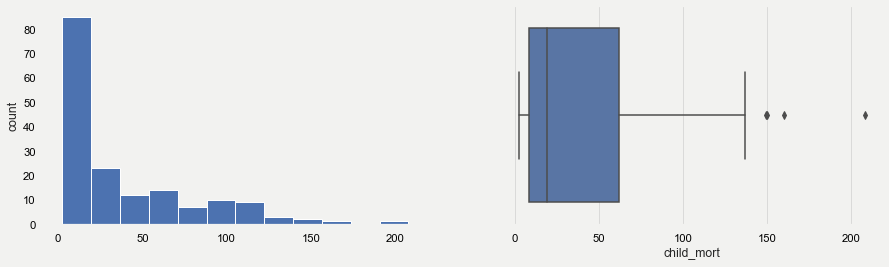

         count       mean       std    min   25%   50%    75%    max      skew
exports  167.0  41.108976  27.41201  0.109  23.8  35.0  51.35  200.0  2.445824


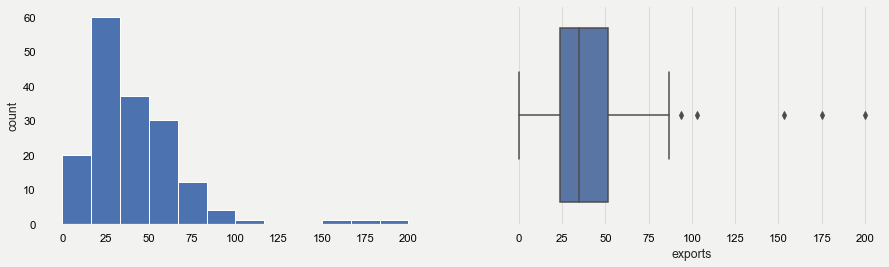

        count      mean       std   min   25%   50%  75%   max      skew
health  167.0  6.815689  2.746837  1.81  4.92  6.32  8.6  17.9  0.705746


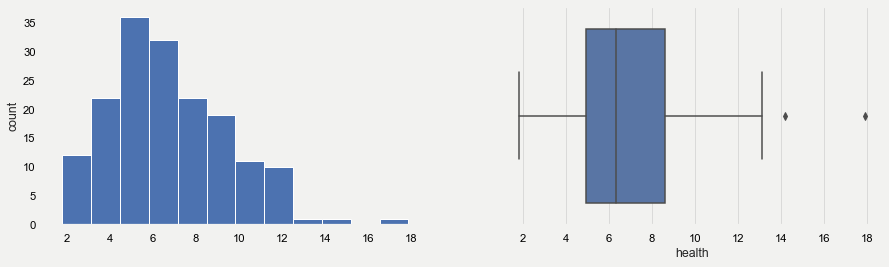

         count       mean        std     min   25%   50%    75%    max  \
imports  167.0  46.890215  24.209589  0.0659  30.2  43.3  58.75  174.0   

             skew  
imports  1.905276  


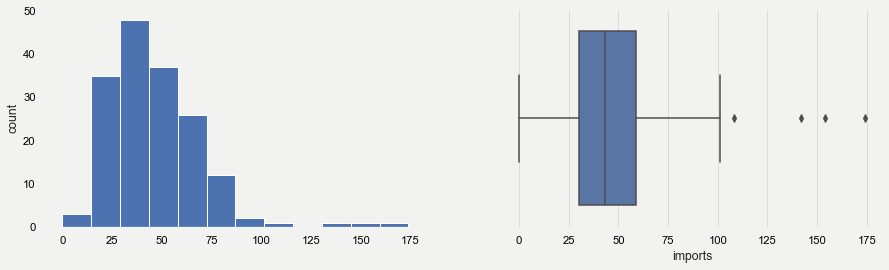

        count          mean           std    min     25%     50%      75%  \
income  167.0  17144.688623  19278.067698  609.0  3355.0  9960.0  22800.0   

             max     skew  
income  125000.0  2.23148  


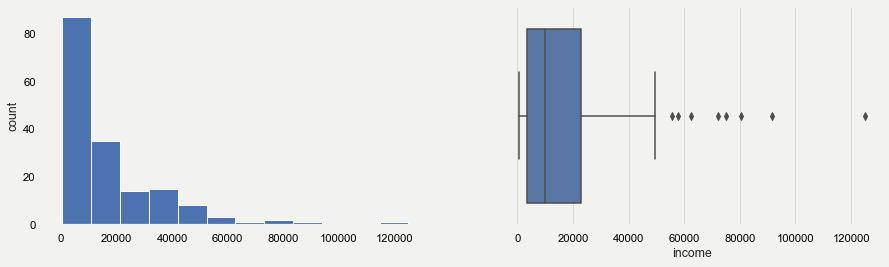

           count      mean        std   min   25%   50%    75%    max  \
inflation  167.0  7.781832  10.570704 -4.21  1.81  5.39  10.75  104.0   

               skew  
inflation  5.154049  


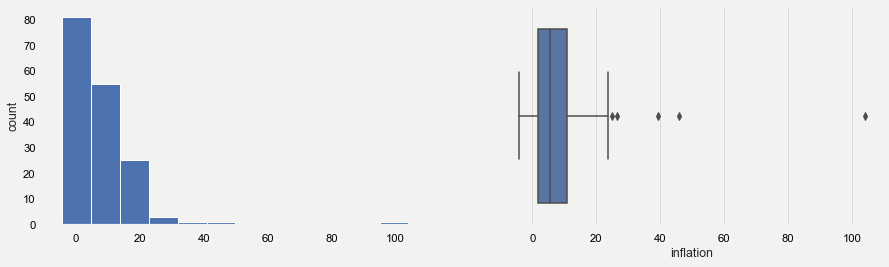

            count       mean       std   min   25%   50%   75%   max      skew
life_expec  167.0  70.555689  8.893172  32.1  65.3  73.1  76.8  82.8 -0.970996


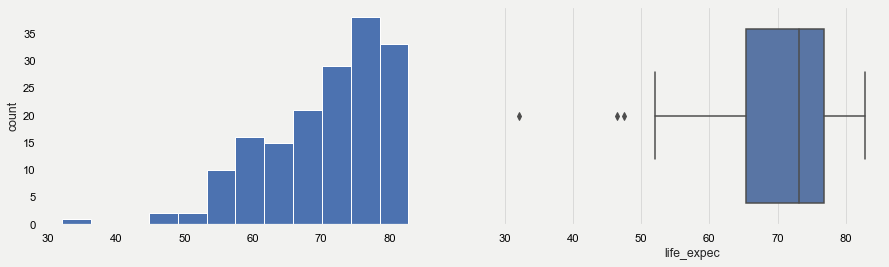

           count      mean       std   min    25%   50%   75%   max      skew
total_fer  167.0  2.947964  1.513848  1.15  1.795  2.41  3.88  7.49  0.967092


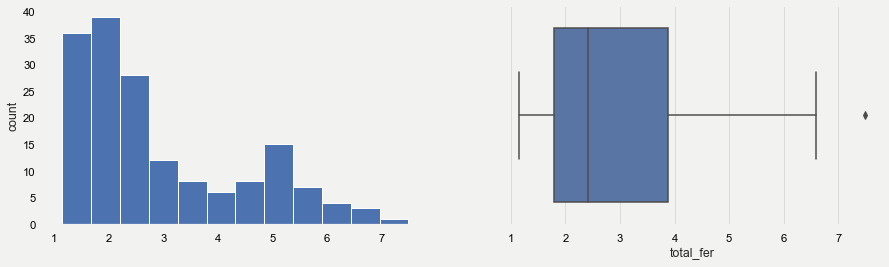

      count          mean           std    min     25%     50%      75%  \
gdpp  167.0  12964.155689  18328.704809  231.0  1330.0  4660.0  14050.0   

           max      skew  
gdpp  105000.0  2.218051  


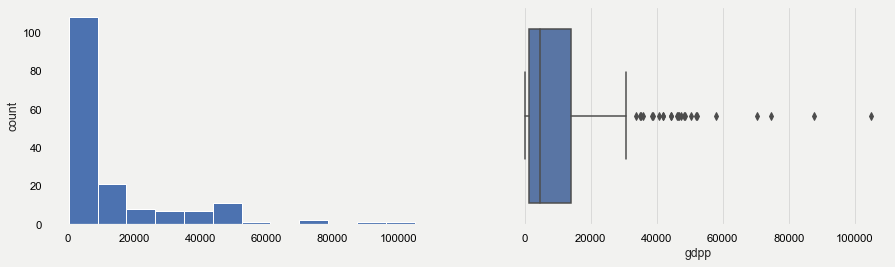

In [10]:
n_bins = int(np.sqrt(len(data)))

for col in data.columns[1:]:
    tmp_desc = data[[col]].describe().T
    tmp_desc['skew'] = data[col].skew()
    print(tmp_desc)
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=n_bins, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- As observed earlier, most of the variables have skewed distributions
- The distribution for the % expenditure on health is relatively less skewed with fewer outliers
- The life expectancy is the only variable which is skewed to the left meaning most of the countries have already been successful in achieving high life expectancy
- The distribution for all other variables is highly skewed to the right. All these variables have some outliers to the right end.

**Let's check the correlation among the variables**

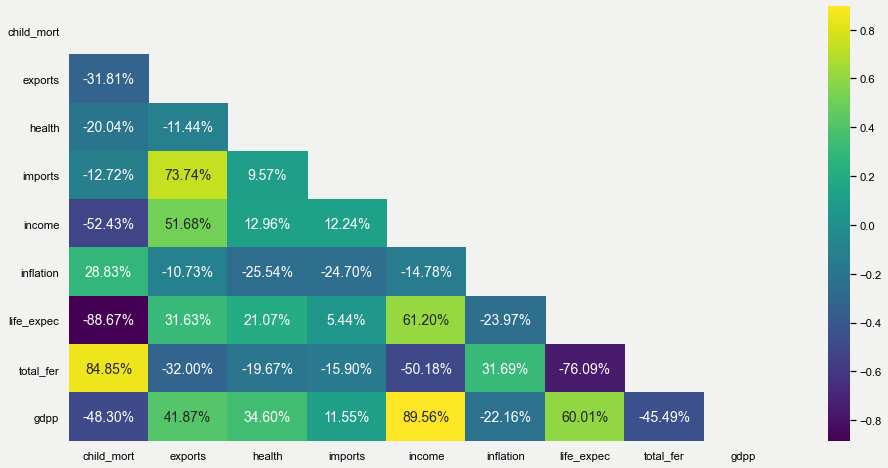

In [11]:
triag_corr(
    df=data, 
    fig_xy=[16,8],
    abs_=False,
    cmap='viridis',
    method='pearson',
    fmt='.2%',
    annot_s=14
)

In [12]:
mu_abs_corr, std_abs_corr = mu_std_corr_matrix(corr=data.corr(), rnd=3)
top_abs_corrs = get_top_abs_correlations(data.drop('country', axis=1), 20)
top_abs_corrs.head()

Correlation
X          y                      
income     gdpp           0.895571
child_mort life_expec     0.886676
           total_fer      0.848478
life_expec total_fer      0.760875
exports    imports        0.737381

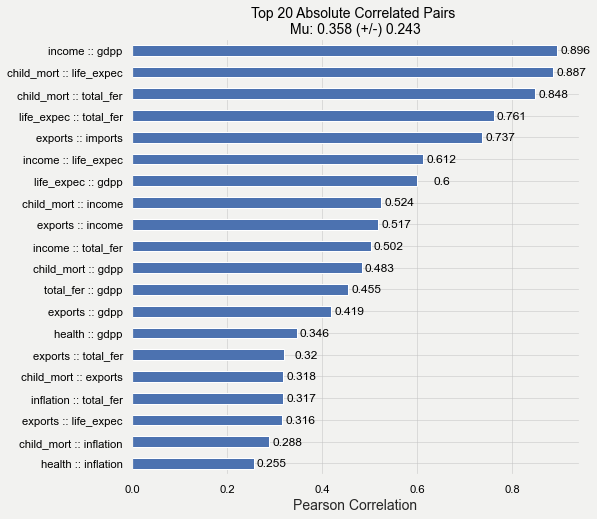

In [13]:
abs_corrs_idx = [str(i)+' :: '+str(x) for i, x in zip(top_abs_corrs.index.droplevel(1), top_abs_corrs.index.droplevel(0))]
top_abs_corrs = pd.DataFrame(top_abs_corrs.values, index=abs_corrs_idx, columns=['Correlation'])

fig, ax = plt.subplots(figsize=(8,8))
top_abs_corrs.sort_values('Correlation').plot(kind='barh', ax=ax, legend=False)
for i, v in enumerate(top_abs_corrs.sort_values('Correlation').values):
    ax.text(x=v + 0.07, y=i, s=str(round(v[0],3)), fontweight='medium', fontsize=12, 
        va='center', ha='right')
plt.title(f'Top 20 Absolute Correlated Pairs \nMu: {mu_abs_corr} (+/-) {std_abs_corr}', fontsize=14)
plt.xlabel('Pearson Correlation', fontsize=14);

**Observations:**

- There is a strong positive correlation between gdpp and income. This makes sense. 
- The life expectancy is positively correlated with gdpp. This indicates that people live longer in richer countries. 
- There is a strong negative correlation between life expectancy and child mortality. This is understandable.
- The child mortality has a strong positive correlation with fertility rate. This indicates that increasing population leads to higher child mortality.

## Scaling the data

- Clustering algorithms are distance based algorithms and all distance based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering algorithms.
- We will drop the variables `'country'` and `'gdpp'` before scaling the data as we would not use these two variables for clustering the countries.

In [14]:
data_new = data.drop(columns=["country", "gdpp"])

In [15]:
#Scaling the data and storing the output as a new dataframe
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data_new), columns=data_new.columns)

data_scaled.head()

child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer  
0   1.902882  
1  -0.859973  
2  -0.038404  
3   2.128151  
4  -0.541946

In [16]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy()

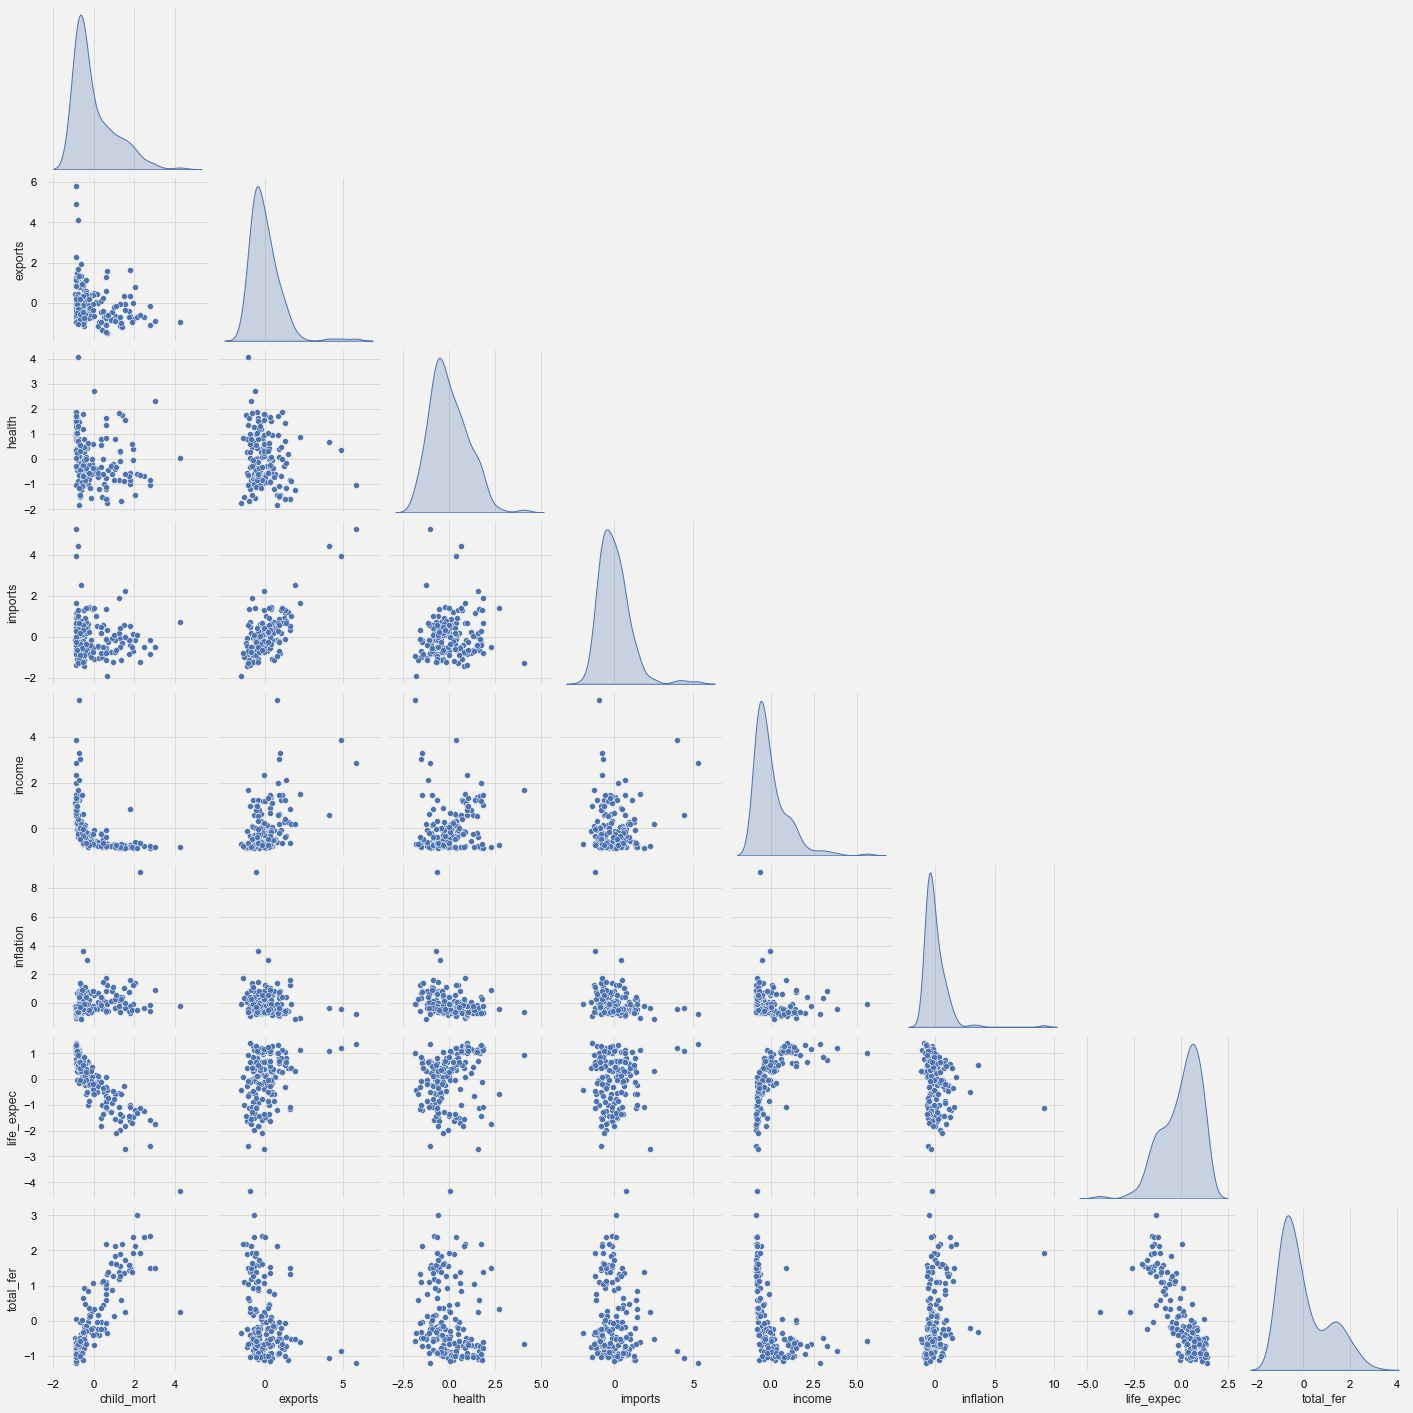

In [17]:
sns.pairplot(data_scaled, diag_kind='kde', corner=True);

## K-Means Clustering

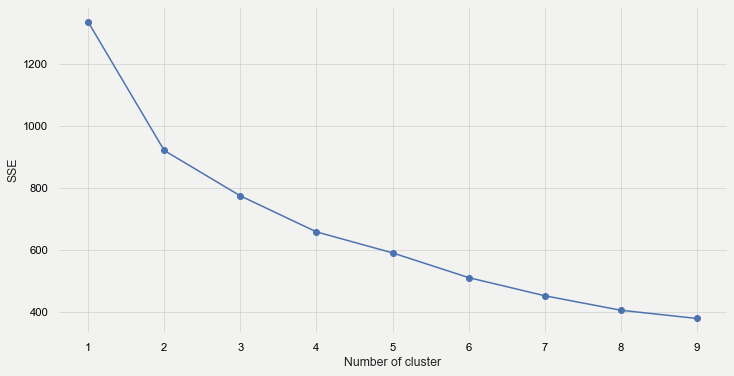

In [18]:
# Empty dictionary to store the SSE for each value of k
sse = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

#Elbow plot
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()), 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**Observations:**

- We can see from the plot that there is a consistent dip from 2 to 8 and there doesn't seem to be a clear 'elbow' here. We may chose any from 2 to 8 as our # of clusters. 
- So, let's look at another method to get a 'second opinion from maths'. Let's create a plot with Silhouette scores to see how it varies with k.

In [19]:
from joblib import Parallel, delayed

def score_tsne_silhouette(X: np.array, n_comp: int = 2, k: int = 3, p: int = 50, rs: int = 1):
    X = TSNE(n_components=n_comp, perplexity=p, n_jobs=-1, random_state=rs).fit_transform(X)
    clusterer = KMeans(n_clusters=k, random_state=rs)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return (silhouette_avg, k, p)

def find_tsne_k_perplexity(X: np.array, n_comp: int, n_clusters: list, perps: list, rs: int = 1, 
                           n_jobs: int = -1, V: int = 5) -> pd.DataFrame:
    out = Parallel(n_jobs=n_jobs, verbose=V)\
                  (delayed(score_tsne_silhouette)\
                  (X, n_comp, k, p, rs) for k in n_clusters for p in perps)
    result_df = pd.concat([
        pd.DataFrame(out[i]).T for i in range(len(out))
    ], axis=0).rename(columns={0:'Silhouette_Score', 1:'K', 2:'Perplexity'})\
              .reset_index(drop=True).sort_values('Silhouette_Score', ascending=False)
    return result_df

In [20]:
perps = list(range(5, 51))
n_clusters = list(range(3, 11))

result_df = find_tsne_k_perplexity(
    X=data_scaled.values,
    n_comp=2,
    n_clusters=n_clusters,
    perps=perps,
    rs=1,
    n_jobs=-1,
    V=5
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:   15.5s finished


In [21]:
result_df.head()

Silhouette_Score     K  Perplexity
138          0.535305   6.0         5.0
4            0.530353   3.0         9.0
139          0.529550   6.0         6.0
92           0.523407   5.0         5.0
324          0.522543  10.0         7.0

In [22]:
X_tsne = TSNE(
    n_components=2, 
    random_state=1, 
    perplexity=5, 
    n_jobs=-1
).fit_transform(data_scaled)

kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(X_tsne)
labels = kmeans.predict(X_tsne)

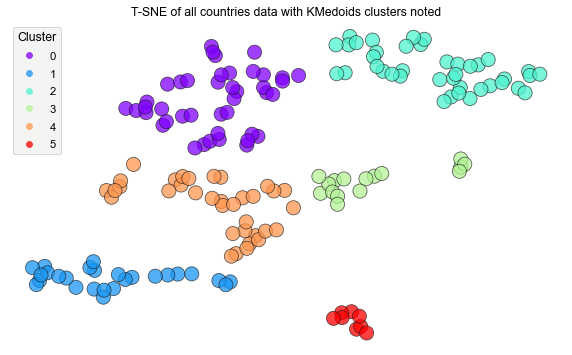

In [23]:
plt.figure(1, facecolor='white', figsize=(10, 6))
plt.clf()
plt.axis('off')

scatter0 = plt.scatter(X_tsne[:,0], X_tsne[:,1], s=200, alpha=0.75,
                       c=labels[labels!=-1], cmap='rainbow', edgecolors='k', lw=0.75)

plt.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
plt.title('T-SNE of all countries data with KMedoids clusters noted');

In [24]:
data_scaled_copy['TSNE_KMeans_Labels'] = kmeans.predict(X_tsne)
data['TSNE_KMeans_Labels'] = kmeans.predict(X_tsne)

In [25]:
mean = data.groupby('TSNE_KMeans_Labels').mean()
median = data.groupby('TSNE_KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median',
                   'group_3 Mean', 'group_3 Median', 'group_4 Median', 'group_4 Median', 'group_5 Mean', 'group_5 Median']
df_kmeans.T

group_0 Mean  group_1 Mean  group_2 Mean  group_0 Median  \
child_mort     28.421429      4.276923     95.632500       48.431250   
exports        27.040214     56.338462     28.825250       44.806250   
health          5.469762     10.084231      5.924250        7.678750   
imports        33.987283     51.911538     38.972500       69.212500   
income      10251.904762  43007.692308   3539.325000     5374.375000   
inflation      12.784786      1.465654     10.773875        5.417500   
life_expec     72.221429     80.953846     59.582500       62.912500   
total_fer       2.510714      1.761154      5.207750        3.180625   
gdpp         5125.380952  46819.230769   1655.375000     2825.812500   

            group_1 Median  group_2 Median  group_3 Mean  group_3 Median  \
child_mort       11.271429        11.43750        20.500          4.2000   
exports          53.437143        65.56250        26.600         39.2000   
health            7.417714         3.35625         5.225          9.6350   
imports          59.262857        39.12500        31.350         37.2500   
income        16772.000000     62475.00000      9440.000      40550.0000   
inflation         3.001229        12.72750         8.090          1.0205   
life_expec       75.434286        76.82500        72.050         80.9500   
total_fer         1.812857         2.30250         2.390          1.8250   
gdpp          10586.285714     31312.50000      4275.000      45350.0000   

            group_4 Median  group_4 Median  group_5 Mean  group_5 Median  
child_mort          90.400           43.55         10.30          10.650  
exports             23.300           47.20         50.20          66.200  
health               5.215            6.81          7.09           3.250  
imports             38.200           74.90         58.10          37.100  
income            1835.000         3915.00      15400.00       51500.000  
inflation            9.345            4.85          2.01          13.350  
life_expec          59.800           64.15         75.80          76.300  
total_fer            5.205            2.99          1.57           2.185  
gdpp               733.000         2520.00       8300.00       27850.000

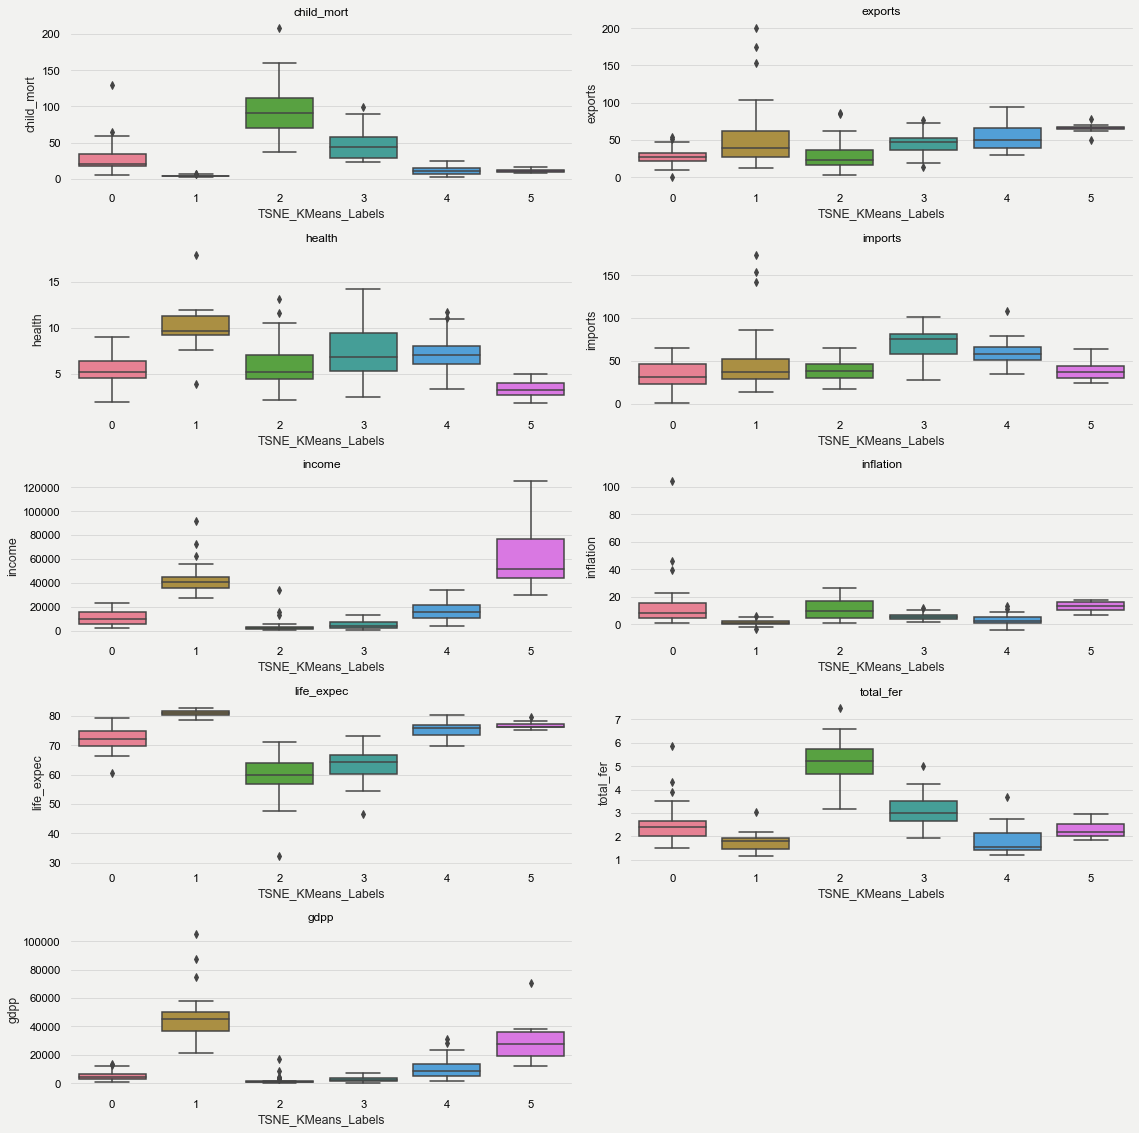

In [26]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 2, i)
    sns.boxplot(x='TSNE_KMeans_Labels', y=feature, data=data, palette='husl')
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

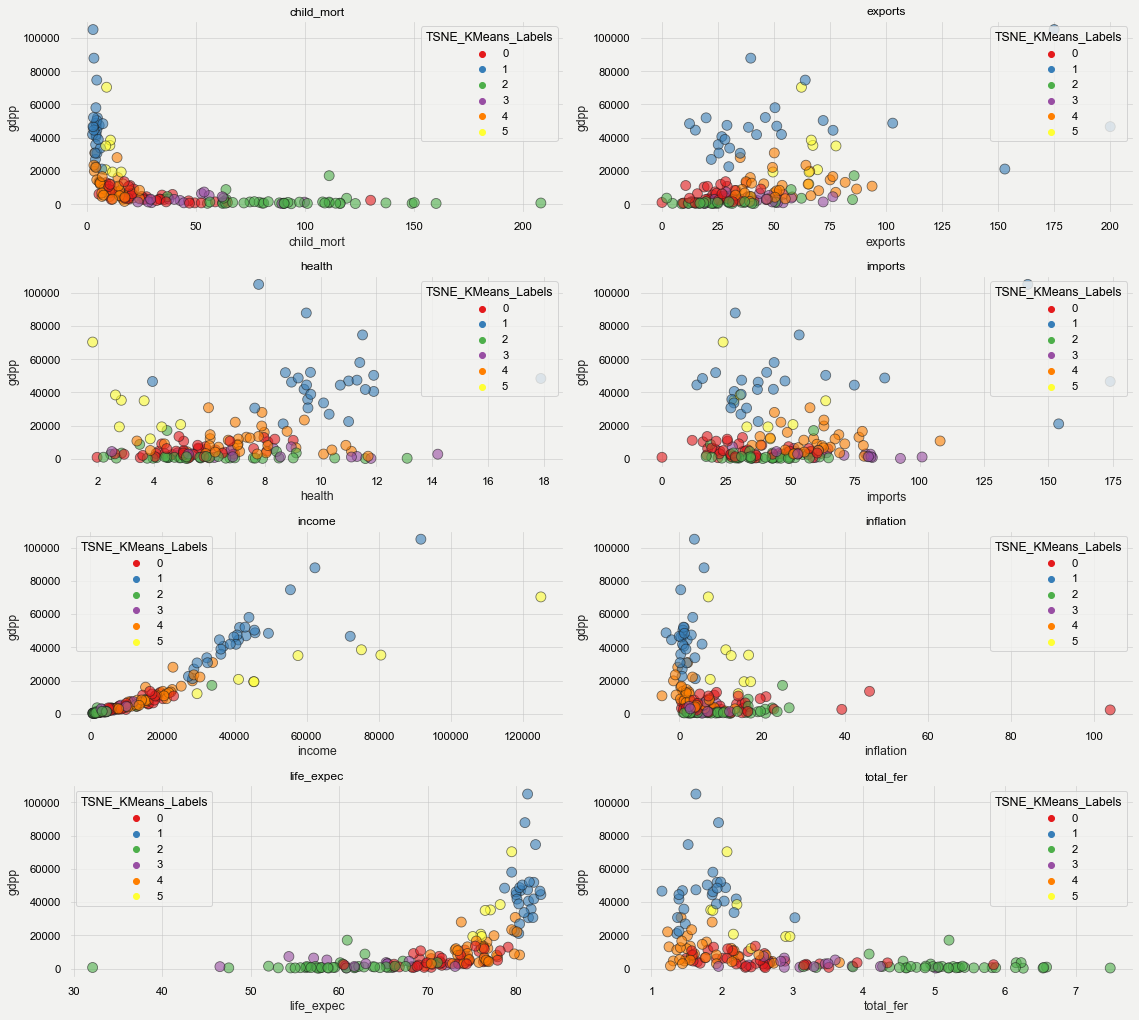

In [27]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 2, i)
    sns.scatterplot(x=feature, y='gdpp', data = data, hue='TSNE_KMeans_Labels', palette='Set1', 
                    alpha=0.6, edgecolor='k', lw=0.5, s=100)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

In [28]:
def show_silhouette(X: np.array, range_n_clusters: list, random_state: int = 1, 
                    reduce_dim: str = 'TSNE', perplexity: int = 50) -> pd.DataFrame:
    silhouette_scores = {}
    
    if reduce_dim == 'TSNE':
        X = TSNE(
            n_components=2, 
            perplexity=perplexity, 
            n_jobs=-1, 
            random_state=random_state
        ).fit_transform(X)
        
    elif reduce_dim == 'PCA':
        X = PCA(n_components=2).fit_transform(X)
        
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores[n_clusters] = silhouette_avg

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.gist_rainbow(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
                    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.gist_rainbow(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=900, lw=0.5, alpha=0.5, c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=0.001, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=200, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      f"with n_clusters = {n_clusters} \nAverage Silhouette Score: {round(silhouette_avg,4)}"),
                     fontsize=14, fontweight='bold')
    plt.show()
    return pd.DataFrame.from_dict(silhouette_scores, orient='index').rename(columns={0:'Avg_Silhouette_Score'})\
                       .rename_axis('k').sort_values('Avg_Silhouette_Score', ascending=False)

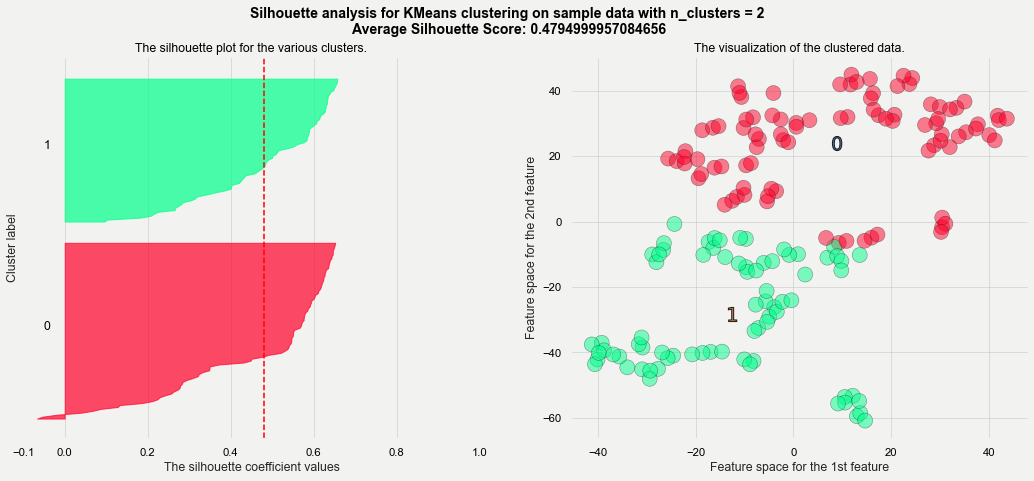

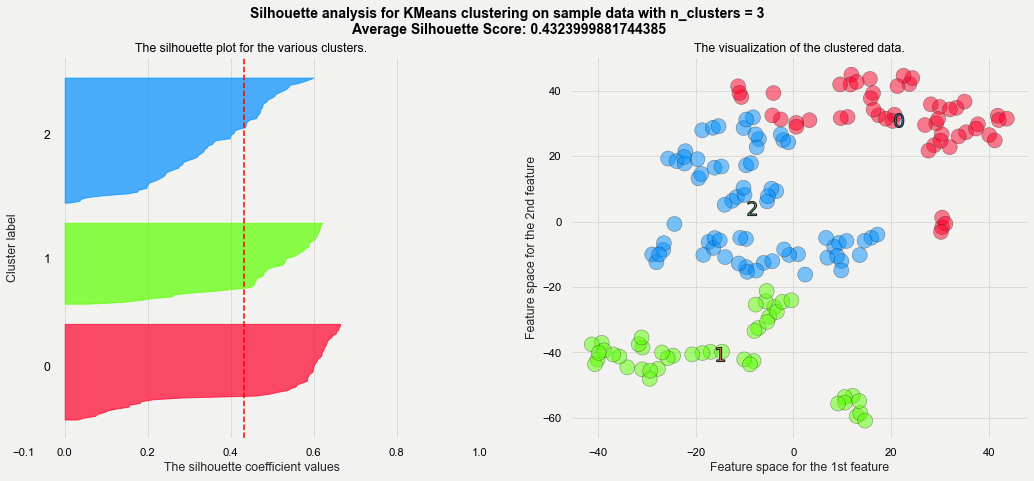

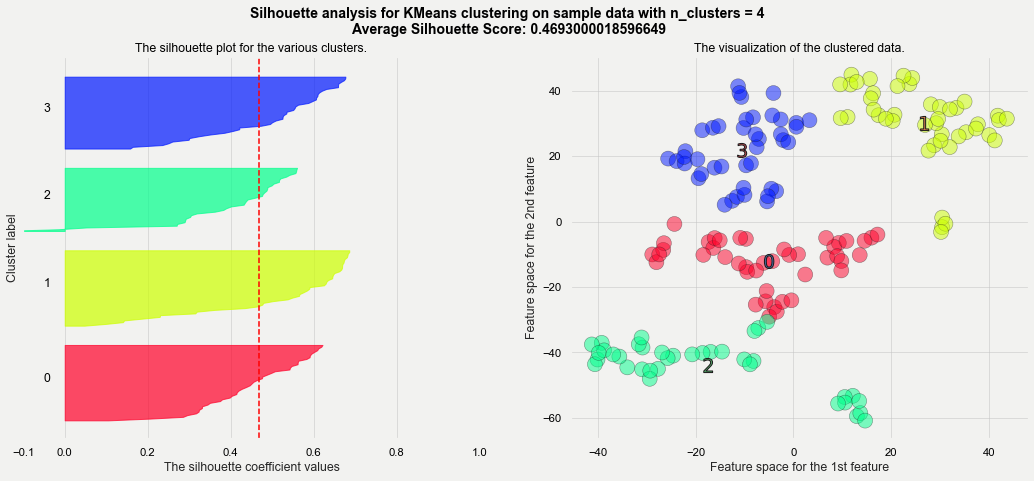

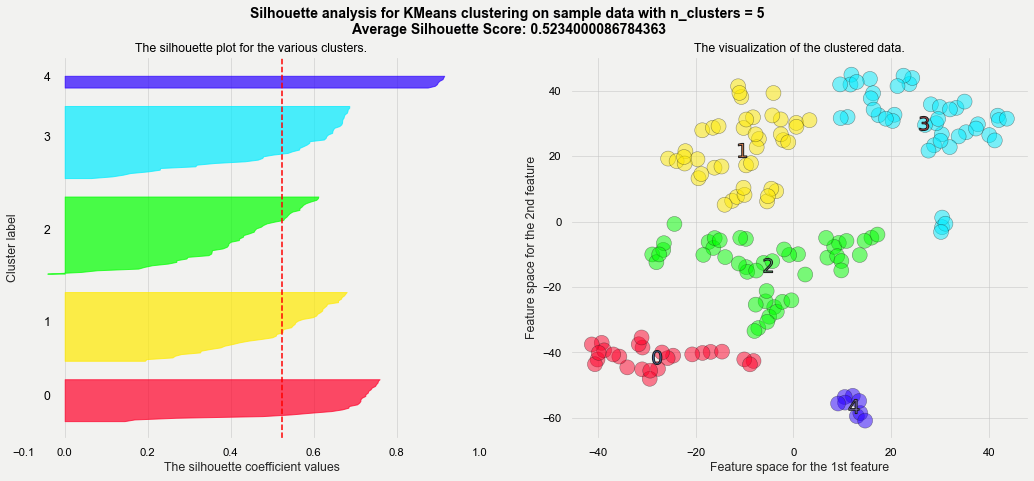

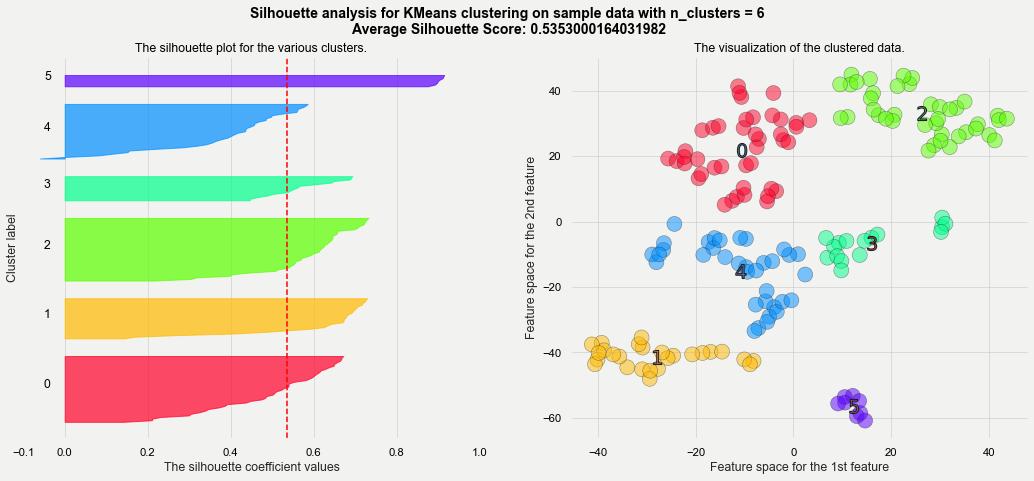

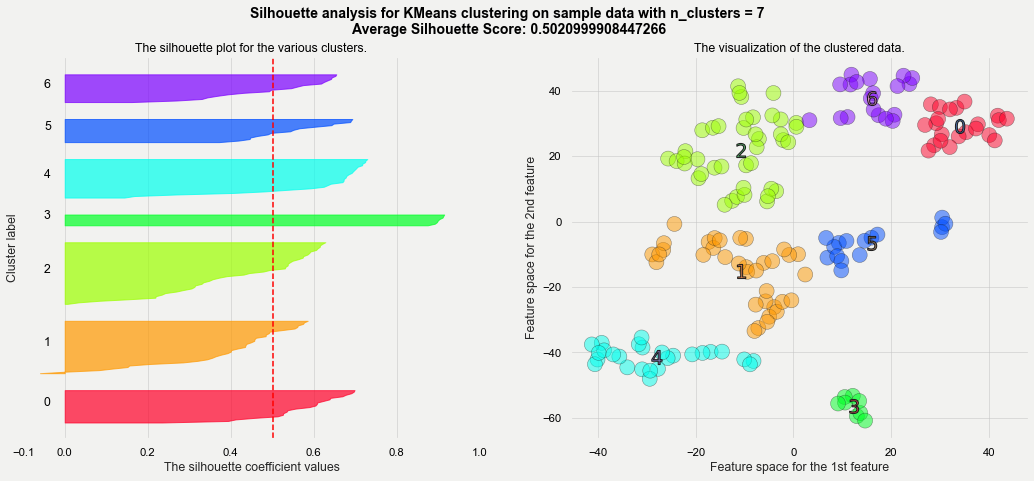

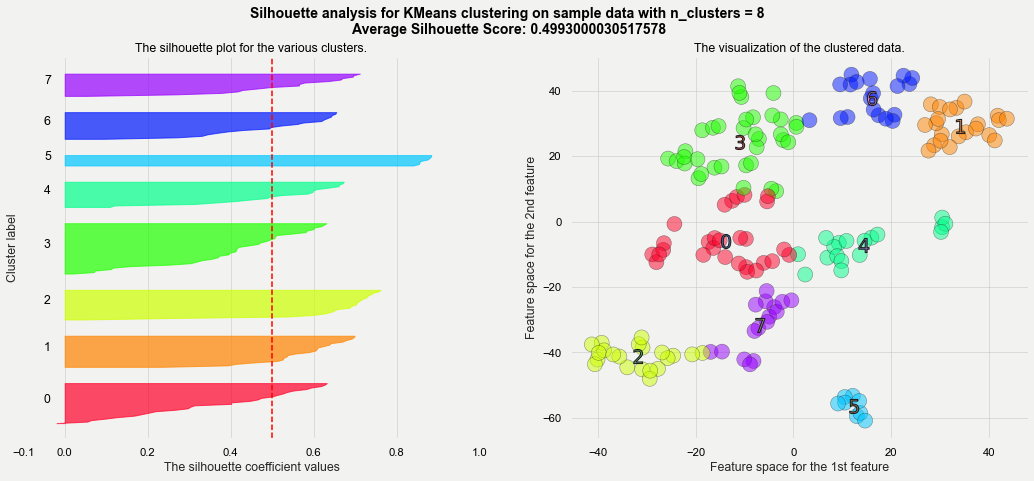

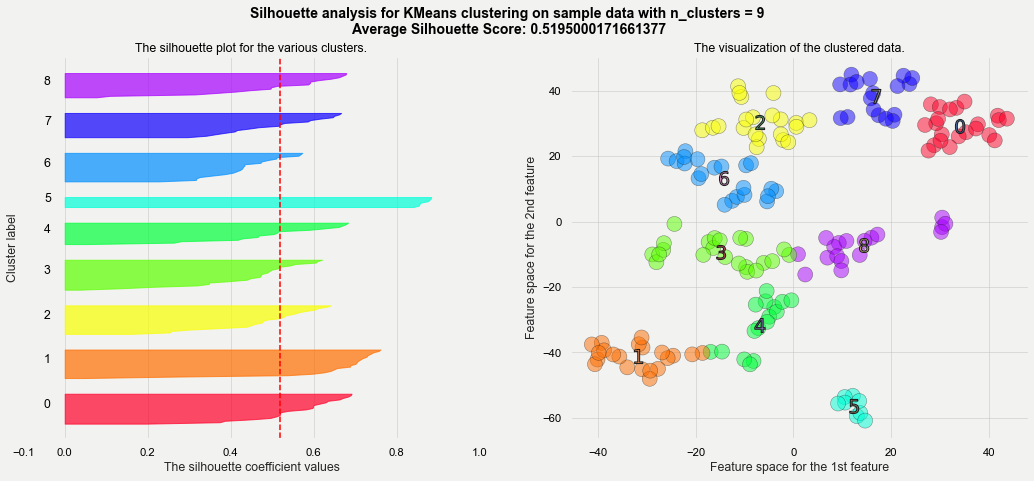

In [29]:
n_clusters = list(range(2, 10))

silhouette_scores = show_silhouette(
    X=data_scaled.values, 
    range_n_clusters=n_clusters,
    reduce_dim='TSNE', 
    perplexity=5
)

In [30]:
silhouette_scores

Avg_Silhouette_Score
k                      
6              0.535305
5              0.523407
9              0.519512
7              0.502094
8              0.499345
2              0.479497
4              0.469272
3              0.432394

**Observations:**

- We can see from the plot that silhouette score is highest for k=3. Well that makes it slightly easy for us and we can start with first understanding these 3 clusters. So let's take the number of clusters as 3.

In [31]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['KMeans_Labels'] = kmeans.predict(data_scaled)
data['KMeans_Labels'] = kmeans.predict(data_scaled)

In [32]:
data['KMeans_Labels'].value_counts()

0    112
1     52
2      3
Name: KMeans_Labels, dtype: int64

**Observations:**

This looks like a very skewed clustering with a very few observations in one cluster and more than 100 in other. Let's check out the profiles of these clusters

In [33]:
#Calculating mean and median of the original data for each label
mean = data.groupby('KMeans_Labels').mean()
median = data.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

group_0 Mean  group_1 Mean  group_2 Mean  group_0 Median  \
child_mort             15.703571     88.844231      4.133333          12.450   
exports                43.487500     28.203827    176.000000          39.600   
health                  7.069464      6.270385      6.793333           6.790   
imports                46.143750     42.164729    156.666667          44.900   
income              22069.285714   3832.750000  64033.333333       16250.000   
inflation               6.042920     11.833750      2.468000           3.810   
life_expec             75.215179     59.892308     81.433333          75.800   
total_fer               2.119821      4.822115      1.380000           1.995   
gdpp                16937.535714   1832.884615  57566.666667        8580.000   
TSNE_KMeans_Labels      2.053571      1.942308      1.000000           1.000   

                    group_1 Median  group_2 Median  
child_mort                   85.65            2.80  
exports                      23.30          175.00  
health                        5.48            7.77  
imports                      39.75          154.00  
income                     1960.00        72100.00  
inflation                     8.95            3.62  
life_expec                   60.45           81.30  
total_fer                     5.00            1.36  
gdpp                        932.00        46600.00  
TSNE_KMeans_Labels            2.00            1.00

**Observations:**

It looks like Cluster 2 is of very rich countries with high income and gdpp, Cluster 1 is of very poor countries with low income and gdp and the rest are in cluster 0, which happens to be the biggest cluster as well. So intuitively this makes sense but let's try to visualize the boxplots of different attributes for each cluster to see if we can spot some more granular patterns.  

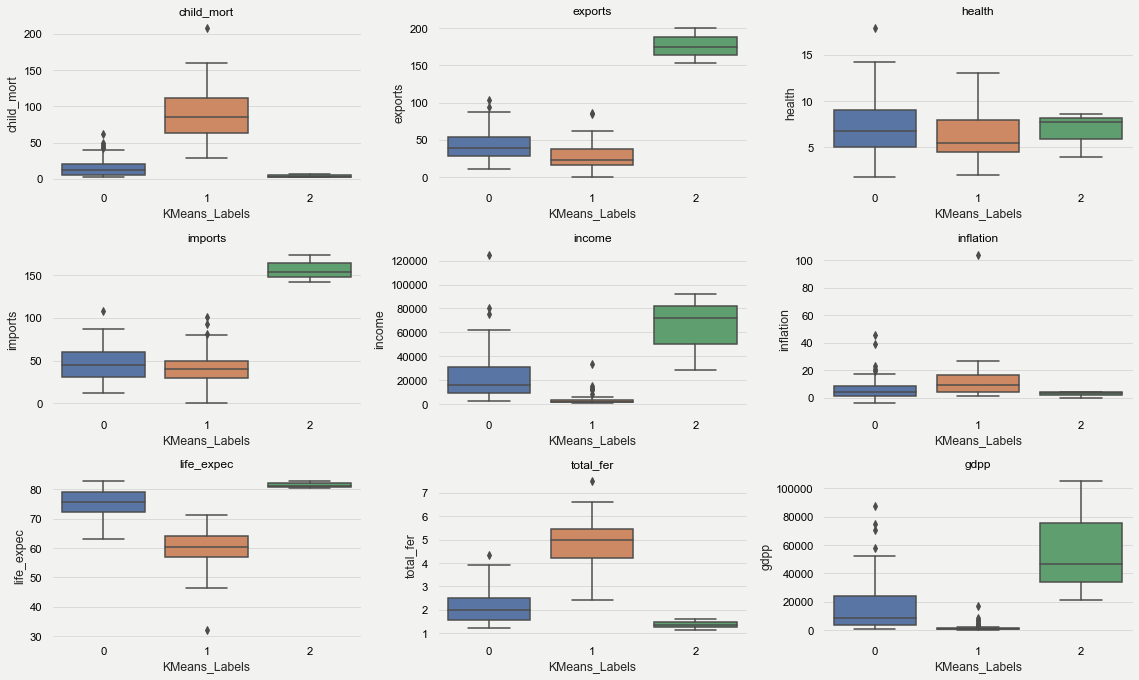

In [34]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 3, i)
    sns.boxplot(x='KMeans_Labels', y=feature, data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Cluster Profiles:**

- Cluster 2 has only 3 observations. As observed from scatter plots and boxplots, group 2 **consists of outlier countries** with highest imports and exports as percentage of GDP. These countries also have very high income.
- Cluster 1 seems to have very poor values for many indicators, like highest inflation rate, lowest GDP per capita, lowest exports as well as imports - all signaling towards very poor economic situation, and they also have the highest child mortality, highest fertility, lowest life expectancy - all signaling towards poor state of health care in the country. This cluster shows traits of  **underdeveloped and developing countries** These countries also seem to have a trade deficit i.e. imports are more the exports. When a country has a trade deficit, it must borrow from other countries to pay for the extra imports.
- Cluster 0 is the largest cluster which shows traits of **developing and developed countries**. The countries in this cluster have comparatively better state of affair for many socio-economic factors but  with a large range of values, indicating that this is a mix of many different types of countries. Ideally, we do not want a cluster to be like this as the fundamental idea behind clustering is to 'group similar things' and this cluster seems to have a lot of 'dissimilarity' within it

- Overall, this clustering solution does give us good insights into potential clusters of similar countries but is not very useful as it is impacted by outlier countries resulting in one very small cluster and two very big clusters. We should try other algorithms to see if we can do better. 


But before that, let's validate if these clusters relate well with the GDP of the country. 

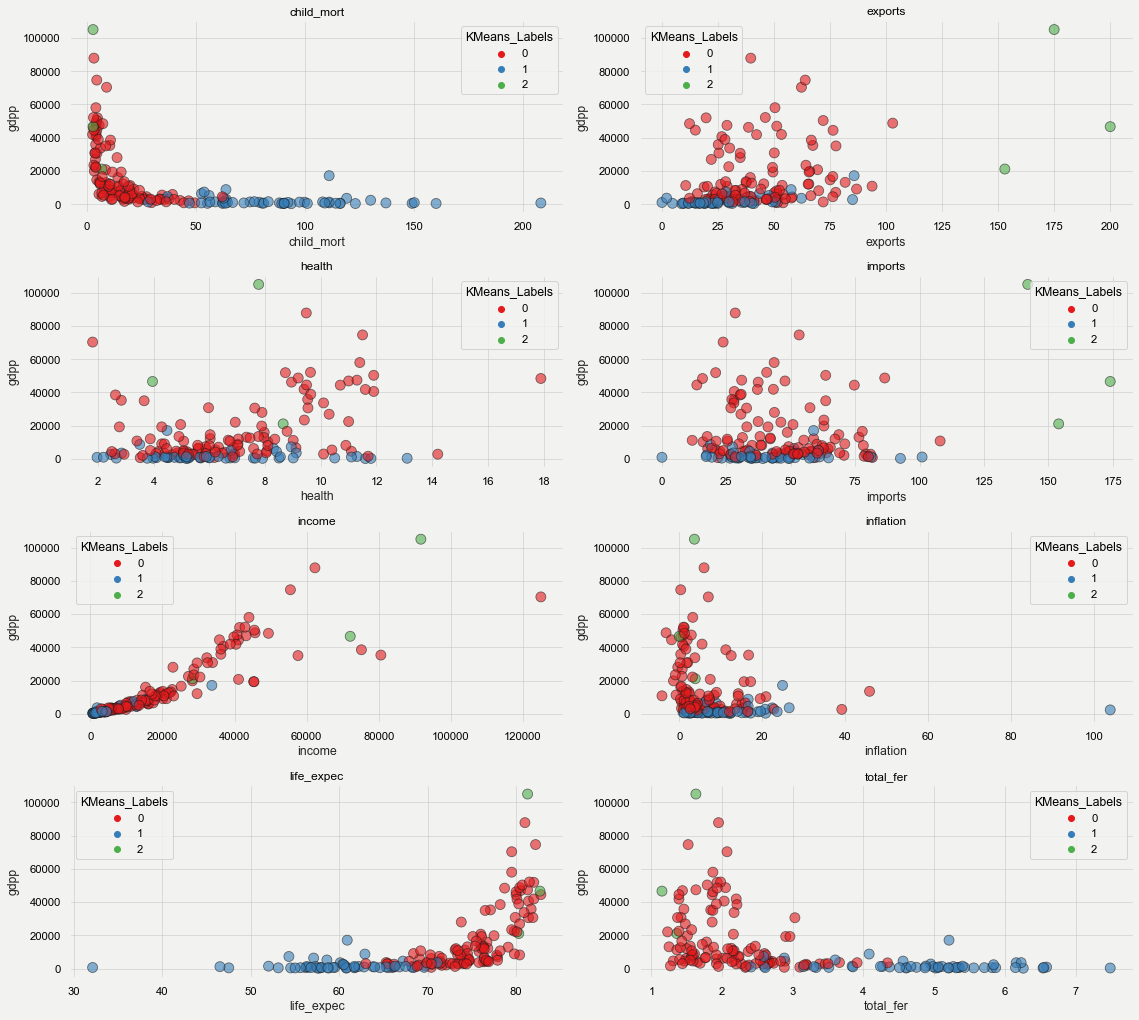

In [35]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 2, i)
    sns.scatterplot(x=feature, y='gdpp', data =data, hue='KMeans_Labels', palette='Set1', 
                    alpha=0.6, edgecolor='k', lw=0.5, s=100)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Observations:**

- As fertility increases the population of the country increase which results in lower GDP and net income per person.
- Child mortality also negatively impacts the GDP of the country. High child mortality can be due to several reasons like higher population of the country, poverty or lower net income per person, lack of health facilities, etc.

Let's try another algorithm

## K-Medoids Clustering

In [36]:
#Install this to package to use KMedoids
#!python -m pip install --user scikit-learn-extra

In [37]:
from sklearn_extra.cluster import KMedoids 

In [38]:
kmedo = KMedoids(n_clusters = 3, random_state=1)
kmedo.fit(data_scaled)

data_scaled_copy['kmedoLabels'] = kmedo.predict(data_scaled)
data['kmedoLabels'] = kmedo.predict(data_scaled)

In [39]:
data.kmedoLabels.value_counts()

1    75
2    58
0    34
Name: kmedoLabels, dtype: int64

In [40]:
X_tsne = TSNE(
    n_components=2, 
    random_state=1, 
    perplexity=50, 
    n_jobs=-1
).fit_transform(data_scaled)

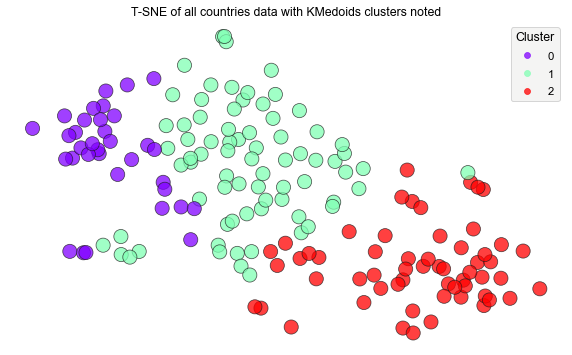

In [41]:
labels = data['kmedoLabels'].values

plt.figure(1, facecolor='white', figsize=(10, 6))
plt.clf()
plt.axis('off')

scatter0 = plt.scatter(X_tsne[:,0], X_tsne[:,1], s=200, alpha=0.75,
                       c=labels[labels!=-1], cmap='rainbow', edgecolors='k', lw=0.75)

plt.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
plt.title('T-SNE of all countries data with KMedoids clusters noted');

In [42]:
#Calculating mean and median of the original data for each label
original_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

mean = data.groupby('kmedoLabels').mean()
median = data.groupby('kmedoLabels').median()
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmedoids[original_features].T

group_0 Mean  group_1 Mean  group_2 Mean  group_0 Median  \
child_mort      7.085294     17.853333     82.951724           4.700   
exports        36.938235     52.989333     28.191362          31.600   
health          9.413235      6.202133      6.086379           9.585   
imports        33.452941     57.694667     40.795964          30.750   
income      38094.705882  17592.800000   4284.189655       36550.000   
inflation       4.020676      5.511573     12.922328           1.825   
life_expec     79.614706     73.870667     60.958621          80.200   
total_fer       1.842353      2.179600      4.589655           1.875   
gdpp        35925.588235  10989.813333   2057.034483       38700.000   

            group_1 Median  group_2 Median  
child_mort           15.70          79.600  
exports              48.30          23.800  
health                6.00           5.275  
imports              55.10          36.800  
income            13500.00        2145.000  
inflation             3.82           9.225  
life_expec           74.10          60.800  
total_fer             2.13           4.875  
gdpp               6230.00         994.000

**Observations:**

It looks like Cluster 0 is of very rich countries with high income and gdpp, Cluster 2 is of very poor countries with low income and gdp and the rest are in cluster 1, which happens to be the biggest cluster as well. So intuitively this makes sense but let's try to visualize the boxplots of different attributes for each cluster to see if we can spot some more granular patterns.  

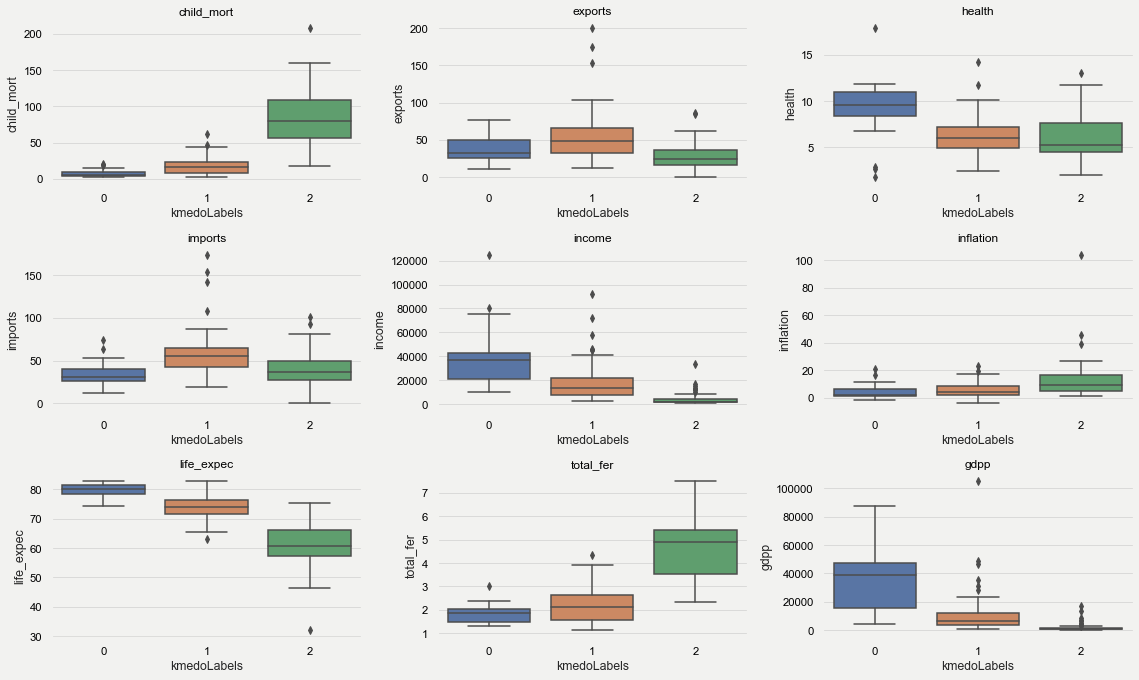

In [43]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 3, i)
    sns.boxplot(x='kmedoLabels', y=feature, data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

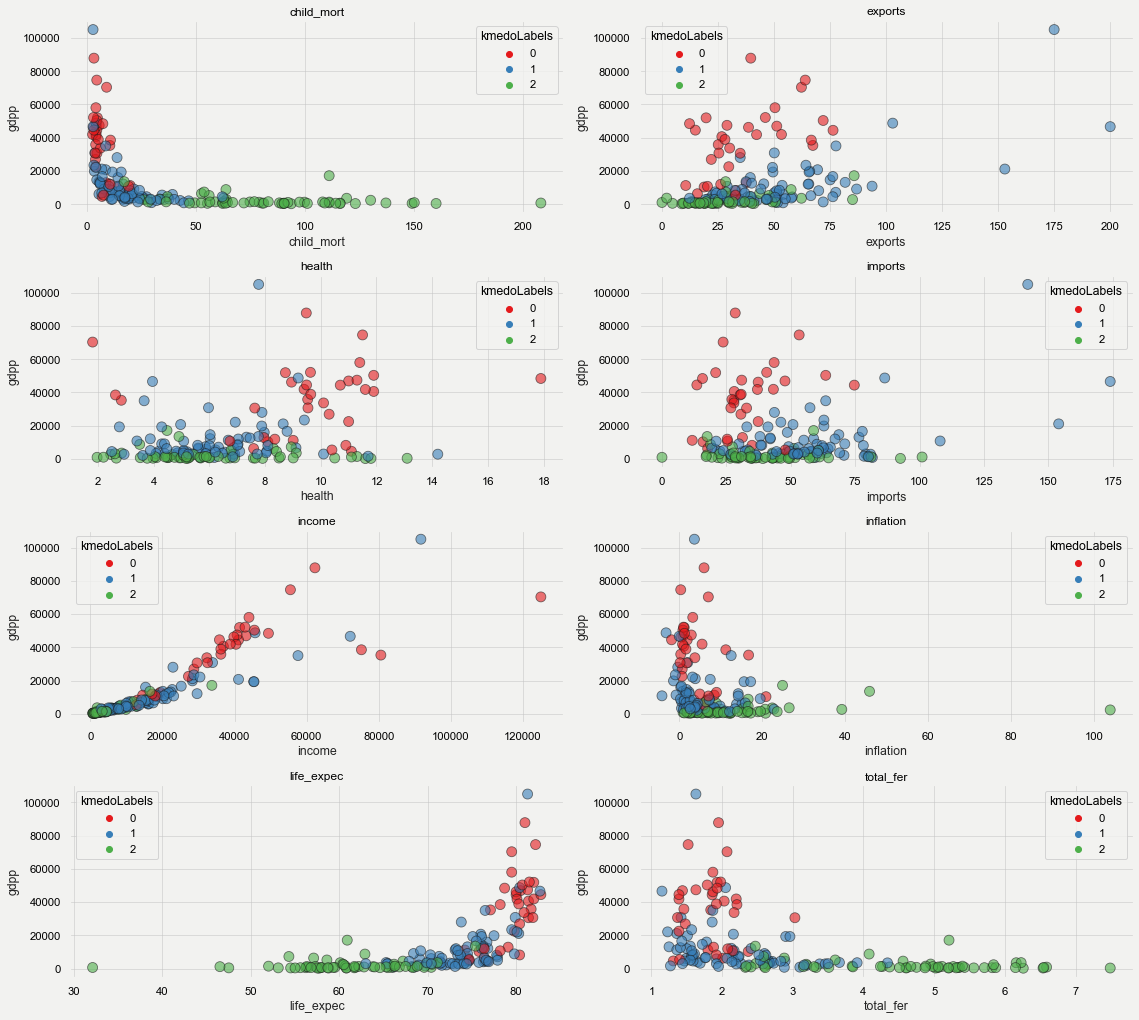

In [44]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 2, i)
    sns.scatterplot(x=feature, y='gdpp', data =data, hue='kmedoLabels', palette='Set1', 
                    alpha=0.6, edgecolor='k', lw=0.5, s=100)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Cluster Profiles:** 

- Cluster 2 countries have the highest average child mortality rate, trade deficit, inflation rate and least average GDP and net income per person. But the large range of values for different variables implies it contains variety of countries from **underdeveloped to developing**. For example, Afghanistan, Bangladesh, Botswana.
- Cluster 1 shows traits of **developing countries** with comparatively higher GDP, net income per person and significantly lower child mortality rate as compared to cluster 2. The cluster consists of some outliers but majorly it consists of countries with low to medium GDP but comparatively higher imports and exports percentage. For example, Albania, Algeria, Antigua and Barbuda.
- Cluster 0 shows traits of **developed countries** with low child mortality rate and higher net income per person, life expectancy, GDP. These countries have the highest average expenditure on health as percentage of GDP. For example, Australia, Austria, Belgium.

**Observations:**

- The count of observations in each clusters from K-Medoids is more evenly distributed as compared to clusters K-Means.
- This is because clusters from K_Medoids are less affected by outliers in the data. As we can observe that three outlier countries (in terms of imports and exports) are included in cluster 1 and do not form a separate cluster like in K-Means.
- Unlike K-Means, the cluster for developed countries is much bigger but still retains the overall characteristics of developed countries as reflected in higher values for income per person, life expectancy etc. and especially in health expenditure as percentage of GDP.

Now, let's see what we get with GMM

## Gaussian Mixture Clustering

In [45]:
gmm = GaussianMixture(n_components = 3, random_state = 1)
gmm.fit(data_scaled)

data_scaled_copy['GmmLabels'] = gmm.predict(data_scaled)
data['GmmLabels'] = gmm.predict(data_scaled)

In [46]:
data.GmmLabels.value_counts()

0    67
2    62
1    38
Name: GmmLabels, dtype: int64

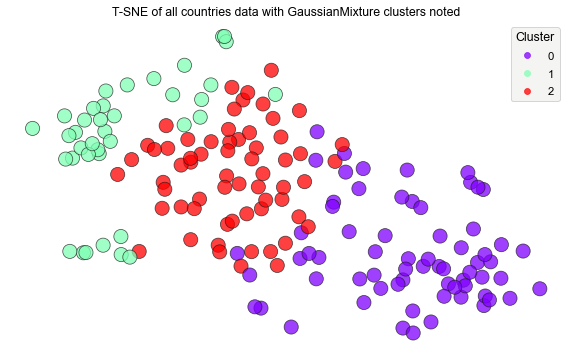

In [47]:
labels = data['GmmLabels'].values

plt.figure(1, facecolor='white', figsize=(10, 6))
plt.clf()
plt.axis('off')

scatter0 = plt.scatter(X_tsne[:,0], X_tsne[:,1], s=200, alpha=0.75,
                       c=labels[labels!=-1], cmap='rainbow', edgecolors='k', lw=0.75)

plt.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
plt.title('T-SNE of all countries data with GaussianMixture clusters noted');

In [48]:
#Calculating mean and median of the original data for each label
original_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

mean = data.groupby('GmmLabels').mean()
median = data.groupby('GmmLabels').median()
df_gmm = pd.concat([mean, median], axis=0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_gmm[original_features].T

group_0 Mean  group_1 Mean  group_2 Mean  group_0 Median  \
child_mort     76.459701      5.544737     17.058065           66.80   
exports        30.704463     60.047368     40.745161           25.00   
health          6.140000      8.444737      6.547419            5.30   
imports        43.886058     51.736842     47.166129           42.90   
income       4578.850746  45431.578947  13386.774194         2520.00   
inflation      11.796642      3.538553      6.043968            8.43   
life_expec     62.070149     79.707895     74.116129           61.80   
total_fer       4.404776      1.791579      2.082419            4.60   
gdpp         2235.880597  40707.105263   7553.870968         1170.00   

            group_1 Median  group_2 Median  
child_mort           4.250          16.550  
exports             50.900          35.400  
health               9.405           6.440  
imports             40.950          48.250  
income           40900.000       12800.000  
inflation            1.395           4.465  
life_expec          80.200          74.150  
total_fer            1.850           2.040  
gdpp             39750.000        6240.000

**Observations:**

It looks like Cluster 1 is of very rich countries with high income and gdpp, Cluster 0 is of very poor countries with low income and gdp and the rest are in cluster 2. So intuitively this makes sense but let's try to visualize the boxplots of different attributes for each cluster to see if we can spot some more granular patterns.  

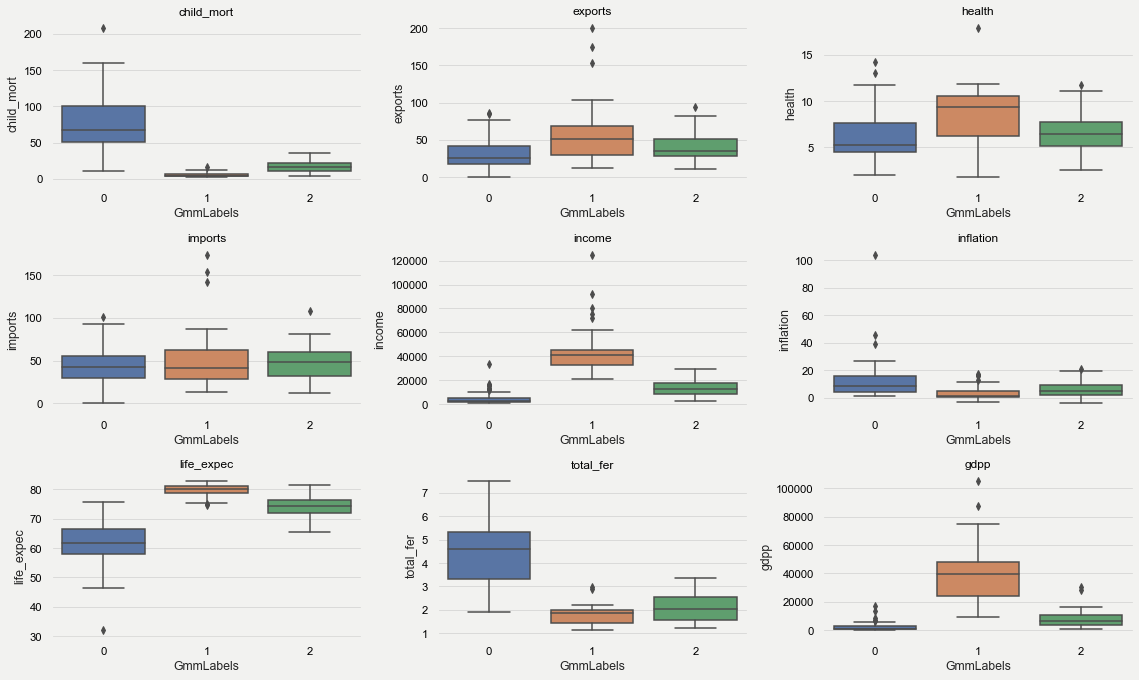

In [49]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 3, i)
    sns.boxplot(x='GmmLabels', y=feature, data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

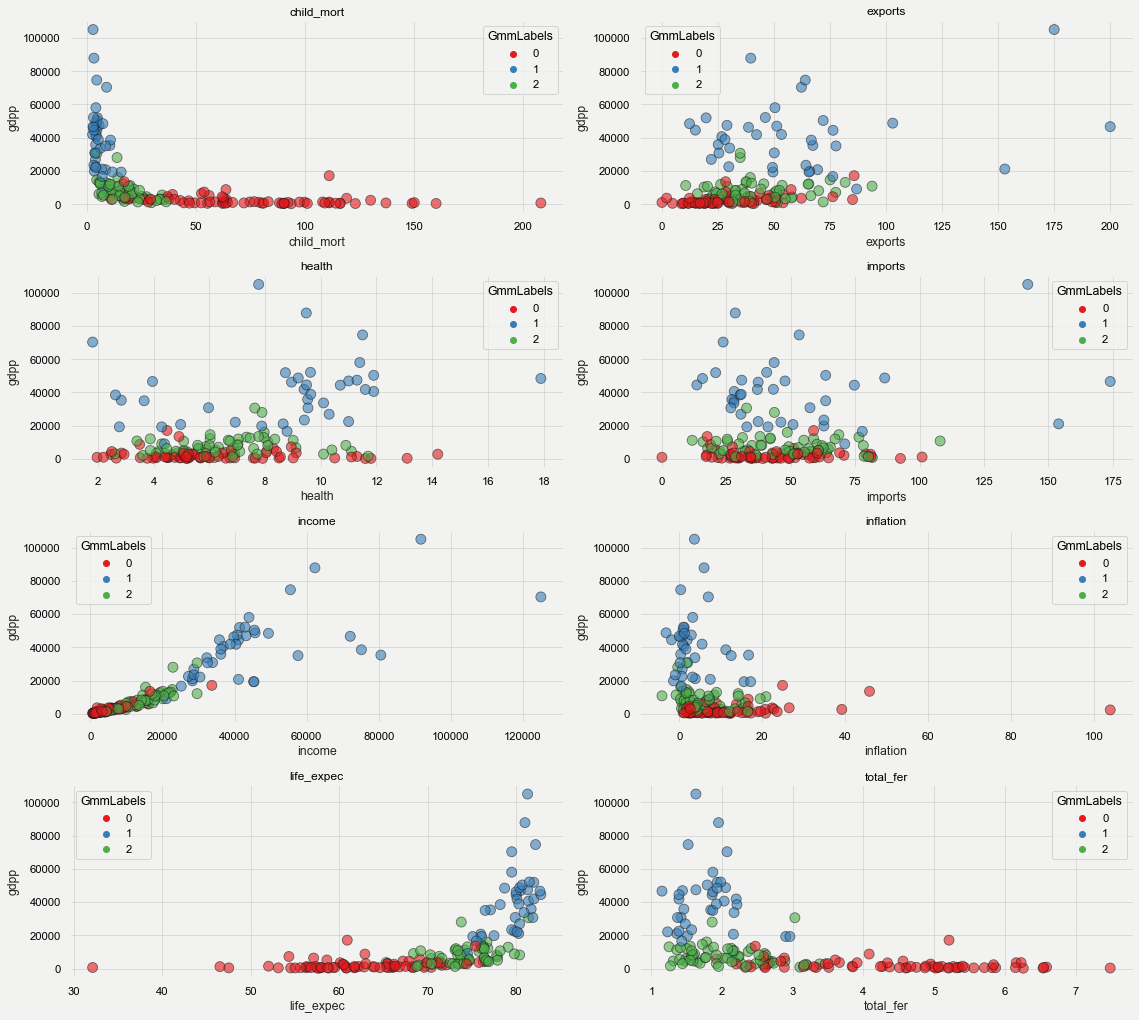

In [50]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 2, i)
    sns.scatterplot(x=feature, y='gdpp', data =data, hue='GmmLabels', palette='Set1', 
                    alpha=0.6, edgecolor='k', lw=0.5, s=100)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Cluster Profiles:**

- This clustering solution looks very similar to the last one created using K-Medoids with one cluster of 'rich' countries, one of 'poor' and one of 'all others'. But on a closer look, we can identify some important differences in this solution using GMM
- Cluster 1 seems to be of 'developed' countries but this time the median values for all key indicators have all improved in comparison to the same cluster obtained from K-Medoids with higher GDP per capita, higher income, higher exports and imports and marginally higher life expectancy. At the same time, it has lower inflation, lower child mortality, lower fertility as well. Overall, we can say that this cluster has become more 'pure' in comparison to the one from K-Medoids.

- Cluster 0 - Seems to be the one of 'underdeveloped' countries but this time the median values for various factors have all improved in comparison to the K-Medoids solution. For e.g., it has higher GDP per capita, higher income per person, higher exports and imports, and slightly better health expenditure and life expectancy.  This means that this cluster of 'underdeveloped' countries has become less 'pure'

- Both of the above points can give an idea of what might have happened to the third cluster i.e. Cluster 2. It was a mix of 'underdeveloped'& 'developing' countries and continues to be so, but some countries on the rich end of the spectrum seemed to have moved to cluster 1, and some countries on the 'underdeveloped' end have moved to the last cluster, thereby reducing itself in size and resulting in different profiles for all clusters. 

Overall, this is a more evenly distributed clustering solution but thereby reducing the 'uniqueness' of the two extreme clusters.


## Hierarchical Clustering

- Let's try to create clusters using Agglomerative Hierarchical clustering. 
- Here, we decide the number of clusters using a concept called `Dendrogram` which is a tree-like diagram that records the sequences of merges or splits.

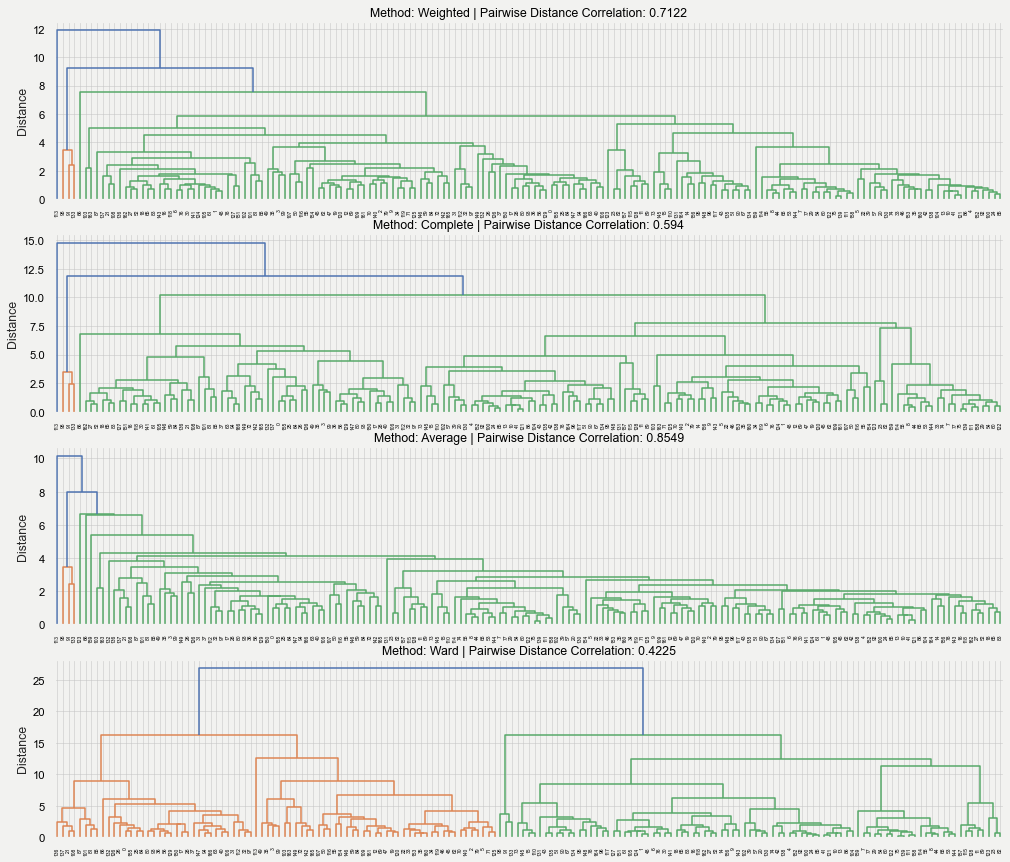

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# List of all linkage methods to check
methods = ['weighted', 'complete', 'average', 'ward']
pairwise_distance = pdist(data_scaled)

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(17, 15))

# Enumerate through the list of all methods above, get linkage and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(data_scaled, metric='euclidean', method=method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Method: {method.capitalize()} | Pairwise Distance Correlation: {round(c,4)}')
    axs[i].set_ylabel('Distance')

**Observations:**

- We can see that complete linkage gives better separated clusters. A cluster is considered better separated if the vertical distance connecting those clusters is high.
- Now, we can set a threshold distance and draw a horizontal line. The number of clusters will be the number of vertical lines which are being intersected by the line drawn using the threshold. 
- The branches of this dendrogram are cut at a level where there is a lot of ‘space’ to cut them, that is where the jump in levels of two consecutive nodes is large
- Here, we can choose to cut it at ~9 since the space between the two nodes is largest.

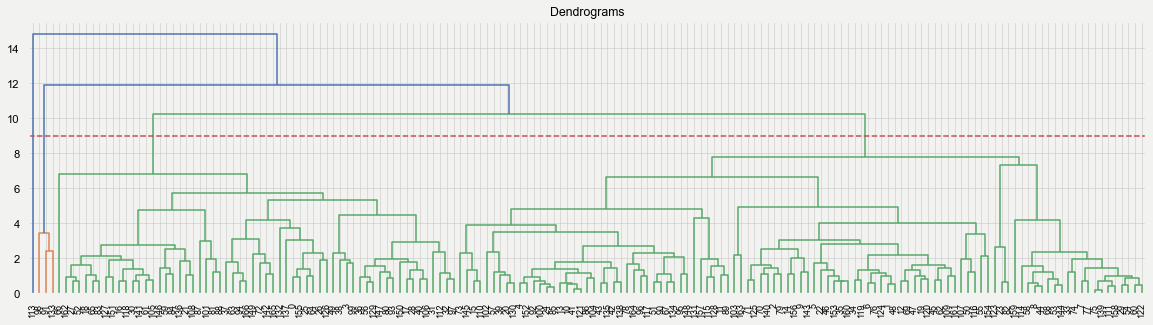

In [52]:
plt.figure(figsize=(20, 5))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(data_scaled, method='complete'), leaf_font_size=9)
plt.axhline(y=9, color='r', linestyle='--');

**Observations:**

- We can see that the if we create a horizontal line at threshold distance ~9, it cuts 4 vertical lines i.e. we get 4 different clusters.  
- Let's fit the algorithms using number of clusters as 4.

In [53]:
#Clustering with number of clusters equal to 4
hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
hierarchical.fit(data_scaled)

AgglomerativeClustering(linkage='complete', n_clusters=4)

In [54]:
data_scaled_copy['HCLabels'] = hierarchical.labels_
data['HCLabels'] = hierarchical.labels_

In [55]:
data.HCLabels.value_counts()

0    103
1     60
2      3
3      1
Name: HCLabels, dtype: int64

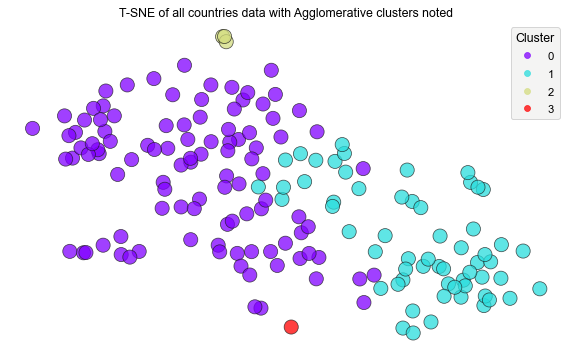

In [56]:
labels = data['HCLabels'].values

plt.figure(1, facecolor='white', figsize=(10, 6))
plt.clf()
plt.axis('off')

scatter0 = plt.scatter(X_tsne[:,0], X_tsne[:,1], s=200, alpha=0.75,
                       c=labels[labels!=-1], cmap='rainbow', edgecolors='k', lw=0.75)

plt.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
plt.title('T-SNE of all countries data with Agglomerative clusters noted');

**Observations:**

- The count of observations in the resulting 4 clusters is unevenly distributed.
- We have two clusters with only 3 and 1 observation. Let's check the countries in these clusters.

In [57]:
#Checking 3 countries in cluster 2
data[data.HCLabels==2]

country  child_mort  exports  health  imports  income  inflation  \
91   Luxembourg         2.8    175.0    7.77    142.0   91700      3.620   
98        Malta         6.8    153.0    8.65    154.0   28300      3.830   
133   Singapore         2.8    200.0    3.96    174.0   72100     -0.046   

     life_expec  total_fer    gdpp  TSNE_KMeans_Labels  KMeans_Labels  \
91         81.3       1.63  105000                   1              2   
98         80.3       1.36   21100                   1              2   
133        82.7       1.15   46600                   1              2   

     kmedoLabels  GmmLabels  HCLabels  
91             1          1         2  
98             1          1         2  
133            1          1         2

**Observations:**

- Similar to K-Means, we got a separate cluster for 3 countries with highest imports and exports i.e. Luxembourg, Malta, Singapore.

In [58]:
#Checking 1 country in cluster 3
data[data.HCLabels==3]

country  child_mort  exports  health  imports  income  inflation  \
113  Nigeria       130.0     25.3    5.07     17.4    5150      104.0   

     life_expec  total_fer  gdpp  TSNE_KMeans_Labels  KMeans_Labels  \
113        60.5       5.84  2330                   0              1   

     kmedoLabels  GmmLabels  HCLabels  
113            2          0         3

**Observations:**

- Cluster 3 consists of just one country - Nigeria. 
- Nigeria has the inflation rate of 104 which is the highest inflation rate (as observed in the summary statistics at the beginning) which might have made its distance with other clusters significantly higher not allowing it to merge with any of the data points.

In [59]:
#Calculating mean and median of the original data for each label
original_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

mean = data.groupby('HCLabels').mean()
median = data.groupby('HCLabels').median()
df_hierachical = pd.concat([mean, median], axis=0)
df_hierachical.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']
df_hierachical[original_features].T

group_0 Mean  group_1 Mean  group_2 Mean  group_3 Mean  \
child_mort     16.678641     75.513333      4.133333        130.00   
exports        42.532806     32.183667    176.000000         25.30   
health          7.013883      6.505667      6.793333          5.07   
imports        42.438504     49.535000    156.666667         17.40   
income      23425.533981   4218.050000  64033.333333       5150.00   
inflation       6.723262      8.261100      2.468000        104.00   
life_expec     75.471845     61.740000     81.433333         60.50   
total_fer       2.074660      4.477333      1.380000          5.84   
gdpp        18053.689320   2174.233333  57566.666667       2330.00   

            group_0 Median  group_1 Median  group_2 Median  group_3 Median  
child_mort           10.80          73.300            2.80          130.00  
exports              38.70          28.900          175.00           25.30  
health                6.91           5.685            7.77            5.07  
imports              38.40          47.650          154.00           17.40  
income            17800.00        2500.000        72100.00         5150.00  
inflation             4.49           5.860            3.62          104.00  
life_expec           76.10          61.300           81.30           60.50  
total_fer             1.93           4.710            1.36            5.84  
gdpp              10700.00        1185.000        46600.00         2330.00

**Observations:**

It looks like Cluster 2 has only 3 countries that is of very rich countries with high income and gdpp, Cluster 1 is of very poor countries with low income and gdp and the rest are in cluster 0 except one country that is in cluster 3. Let's try to visualize the boxplots of different attributes for each cluster to see if we can spot some more granular patterns.  

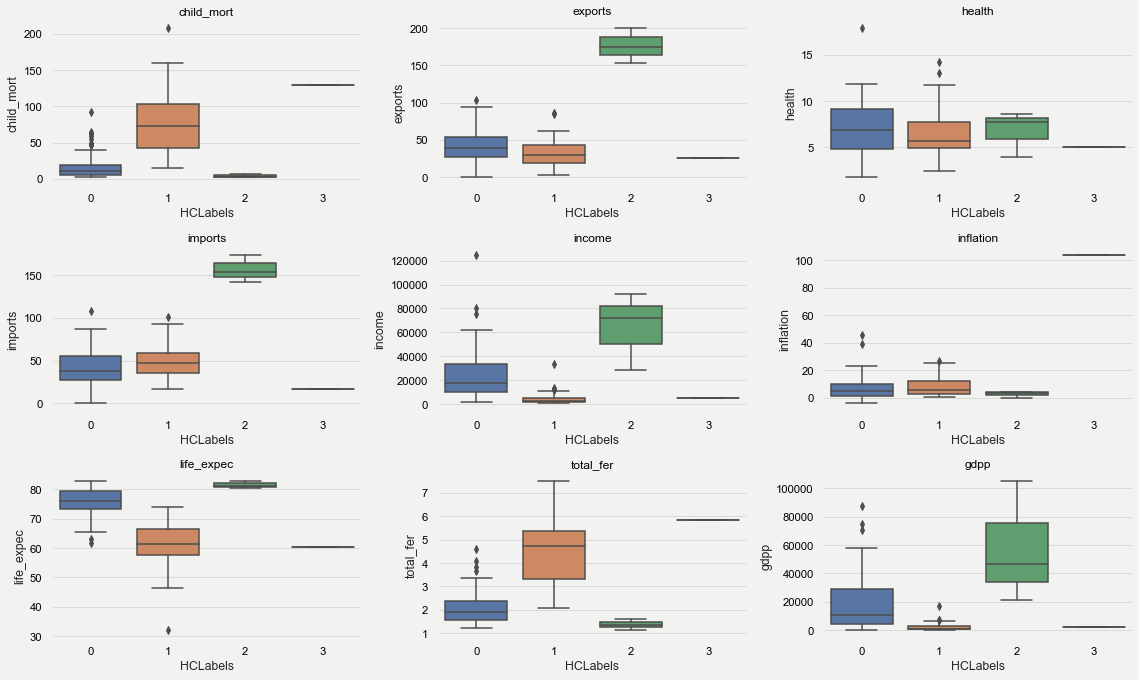

In [60]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 3, i)
    sns.boxplot(x='HCLabels', y=feature, data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Observations:**
- Cluster 1 consists of poor countries which have low income and gdp, high child mortality and fertility rate.
- Cluster 0 has 103 countries which is a mix of different type of counties with different socio-economic factors. It is hard to distinguish and comment on them using this clustering. Therefore, we will not deep dive into the cluster profiles.
- Let's try to use DBSCAN algorithm

## DBSCAN

In [61]:
def plot_dbscan_eps(X: np.array, esp_: list, fig_s: list =[17,80], pca: bool = False) -> None:
    # X = PCA(n_components=2).fit_transform(X) if pca else X
    X = TSNE(n_components=2, perplexity=50, n_jobs=-1).fit_transform(X) if pca else X
    fig = plt.figure(figsize=(fig_s[0], fig_s[1]))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    i = 1
    for i, x in enumerate(esp_):
        db = DBSCAN(eps=x, n_jobs=-1)
        labels = db.fit_predict(data_scaled)
        ax = fig.add_subplot(len(esp_), 3, i+1)
        scatter0 = ax.scatter(X[(labels!=-1), 0], X[(labels!=-1), 1], s=100, alpha=0.7, c=labels[labels!=-1], 
                              cmap='rainbow', edgecolor='k', lw=0.5)
        scatter1 = ax.scatter(X[(labels==-1), 0], X[(labels==-1), 1], s=100, alpha=0.175)
        try:
            legend1 = ax.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
            ax.add_artist(legend1);
        except:
            pass
        ax.set_title(f'eps = {round(x,4)}', fontsize=14)
        i += 1
    plt.tight_layout()
    plt.show()

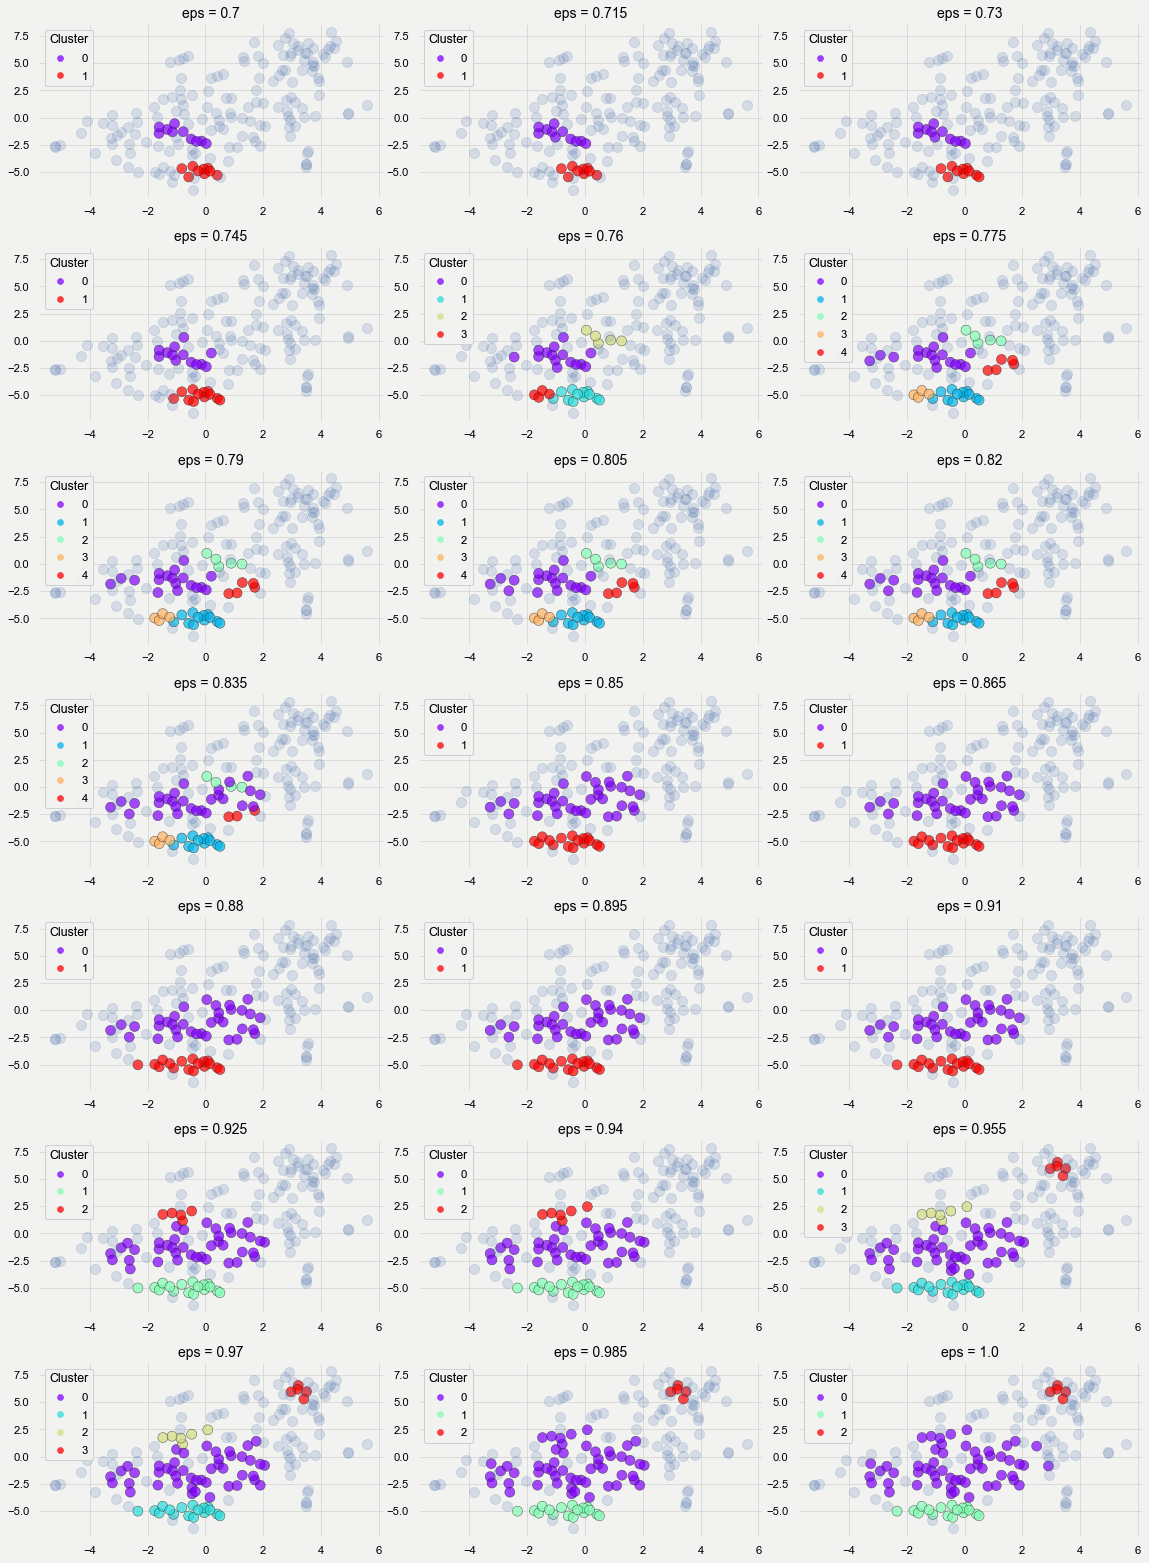

In [62]:
esp_ = np.linspace(0.7, 1, 21)
plot_dbscan_eps(
    X=data_scaled.values, 
    esp_=esp_, 
    fig_s=[16,65], 
    pca=True
)

In [63]:
dbs = DBSCAN(eps=1, n_jobs=-1)
data_scaled_copy['DBSLabels'] = dbs.fit_predict(data_scaled)
data['DBSLabels'] = dbs.fit_predict(data_scaled)

In [64]:
data['DBSLabels'].value_counts()

-1    90
 0    55
 1    17
 2     5
Name: DBSLabels, dtype: int64

In [65]:
labels = data['DBSLabels'].values
clustered_series_all = pd.Series(index=data_scaled.index, data=dbs.labels_.flatten())

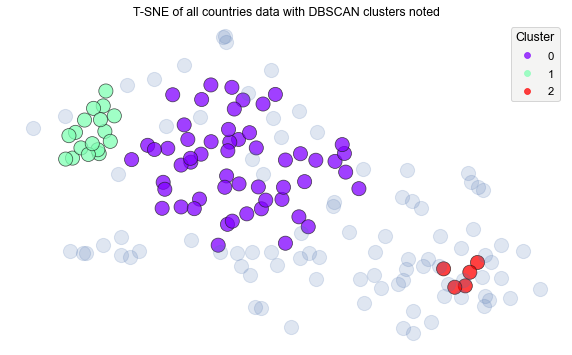

In [66]:
plt.figure(1, facecolor='white', figsize=(10, 6))
plt.clf()
plt.axis('off')

scatter0 = plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s=200, alpha=0.75,
                       c=labels[labels!=-1], cmap='rainbow', edgecolors='k', lw=0.75)

scatter1 = plt.scatter(X_tsne[(clustered_series_all==-1).values, 0], X_tsne[(clustered_series_all==-1).values, 1],
                       s=200, alpha=0.175)

plt.legend(*scatter0.legend_elements(), loc='best', title="Cluster")
plt.title('T-SNE of all countries data with DBSCAN clusters noted');

In [67]:
#Calculating mean and median of the original data for each label
original_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

mean = data.groupby('DBSLabels').mean()
median = data.groupby('DBSLabels').median()
df_hierachical = pd.concat([mean, median], axis=0)
df_hierachical.index = ['group_-1 Mean', 'group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_-1 Median', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_hierachical[original_features].T

group_-1 Mean  group_0 Mean  group_1 Mean  group_2 Mean  \
child_mort      54.907778     17.130909      4.147059        87.340   
exports         42.922211     41.525455     35.194118        24.000   
health           6.254556      6.709455     10.294706         6.256   
imports         48.265177     49.510909     33.982353        37.200   
income       16254.611111  13433.090909  38382.352941      1785.600   
inflation       11.155856      4.015527      1.309118        10.486   
life_expec      67.202222     74.203636     81.076471        55.020   
total_fer        3.578222      2.067455      1.708235         5.504   
gdpp         10940.611111   8043.018182  43200.000000       718.600   

            group_-1 Median  group_0 Median  group_1 Median  group_2 Median  
child_mort           50.900           15.70           4.100           90.20  
exports              36.100           37.00          29.900           22.80  
health                5.275            6.55          10.100            6.01  
imports              42.400           51.30          31.000           34.90  
income             5170.000        11200.00       38800.000         1610.00  
inflation             8.605            3.53           0.873            9.44  
life_expec           67.700           74.50          81.300           54.50  
total_fer             3.250            1.92           1.630            5.43  
gdpp               2775.000         6250.00       41900.000          553.00

**Observations:**

- Cluster 1 seems to have traits of a developed country with high gdp, high income, high expenditure on heath, low child mortality and high life expectancy. The difference in export and import is also small.
- Cluster 2 is very small in size and showing traits of countries which are underdeveloped i.e. with high child mortality and trade deficit, low income and gdp.
- Cluster 0 seems to have traits of developing countries with moderate socio-economic factors.
- Mean and median of group -1 has a large difference implying the presence of outliers in that group.  
- Let's visualize the box plots to comment further on cluster -1

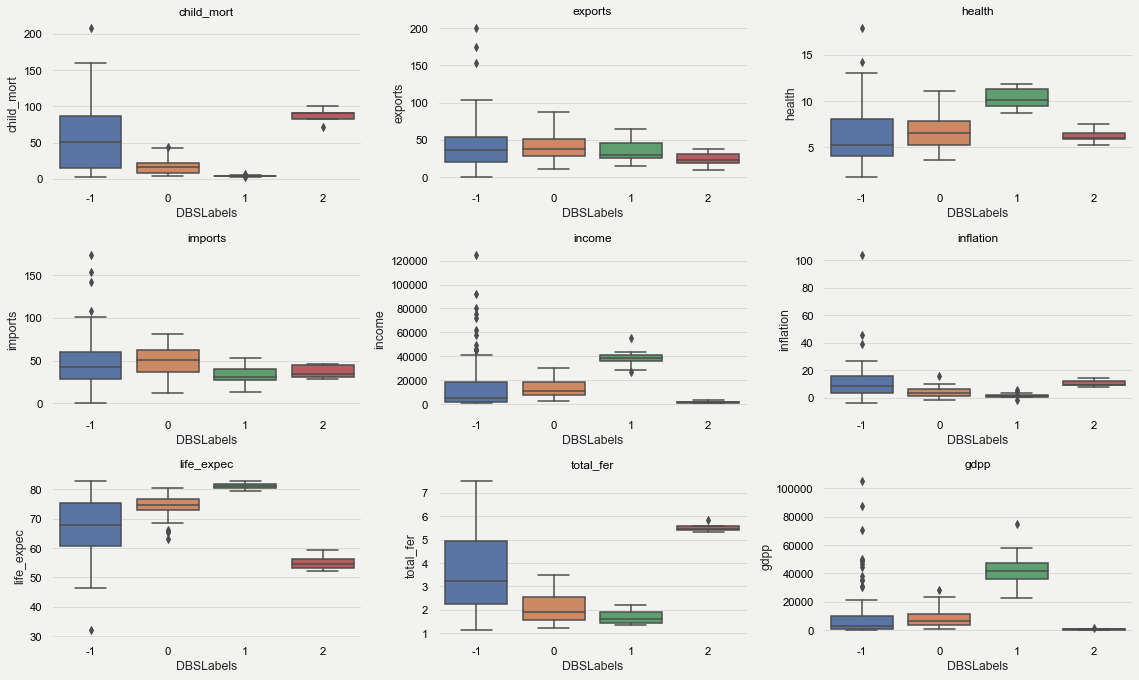

In [68]:
cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,28))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(cols_visualise, 1):    
    plt.subplot(len(cols_visualise), 3, i)
    sns.boxplot(x='DBSLabels', y=feature, data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
plt.tight_layout()       
plt.show()

**Observations**
- We can see that while all the three clusters (0,1,& 2) seems to be way more compact across all attributes, cluster -1 consists all the extreme outliers on at least one attribute. Therefore, it is not adding any value to our cluster analysis. We can explore it more to understand which type of countries it consists.

## Conclusion
Choice of algorithm here will depend on the context and use case. But purely based on foundations of 'what good clustering looks like', one can propose K-Medoids as it has more distinct extreme clusters of developing and underdeveloped countries. 